In [ ]:
import sys, json, os, time
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
SRC_DIR = str(Path(PROJECT_DIR) / "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import multiomic_transformer.utils.experiment_loader as experiment_loader
import multiomic_transformer.datasets.dataset_refactor as dataset_refactor
import multiomic_transformer.models.model as model_module
from multiomic_transformer.datasets.dataset_refactor import MultiChromosomeDataset
from multiomic_transformer.datasets.dataset_refactor import IndexedChromBucketBatchSampler

GROUND_TRUTH_DIR = Path("data/ground_truth_files")

In [ ]:
import importlib
importlib.reload(experiment_loader)

<module 'multiomic_transformer.utils.experiment_loader' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/src/multiomic_transformer/utils/experiment_loader.py'>

: 

## Helper Functions

In [2]:
def format_grad_attrib_grn(grad_attr_np, tf_names, tg_names):
    score = np.nan_to_num(grad_attr_np, nan=0.0)
    score_abs = np.abs(score)
    
    median_val = np.median(score_abs, axis=1, keepdims=True)
    mad = np.median(np.abs(score_abs - median_val), axis=1, keepdims=True) + 1e-6
    score = (score_abs - median_val) / mad
    
    T, G = score_abs.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")
    
    tf_idx = tf_idx.ravel()
    tg_idx = tg_idx.ravel()

    df = pd.DataFrame({
        "Source": np.asarray(tf_names, dtype=object)[tf_idx],
        "Target": np.asarray(tg_names, dtype=object)[tg_idx],
        "Score": score.ravel(),
    })
    
    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()
    
    return df

def format_tf_ko_grn(tf_ko_np, tf_names, tg_names):
    score = np.nan_to_num(tf_ko_np, nan=0.0)
    score = np.maximum(score, 0.0) # Keep only activation-like effects; set inhibition-like effects to 0
    score_abs = np.abs(score)
    
    median_val = np.median(score_abs, axis=1, keepdims=True)
    mad = np.median(np.abs(score_abs - median_val), axis=1, keepdims=True) + 1e-6
    score = (score_abs - median_val) / mad
    
    T, G = score.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")
    
    tf_idx = tf_idx.ravel()
    tg_idx = tg_idx.ravel()

    df = pd.DataFrame({
        "Source": np.asarray(tf_names, dtype=object)[tf_idx],
        "Target": np.asarray(tg_names, dtype=object)[tg_idx],
        "Score": score.ravel(),
    })
    
    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()
    
    return df
            
def find_n_evenly_spaced_checkpoints(exp, n=10):
    checkpoints = sorted([file.name for file in exp.model_training_dir.iterdir() if file.name.startswith("checkpoint_")], key=lambda x: int(x.split("_")[1].split(".")[0]))
    checkpoint_nums = [int(name.split("_")[1].split(".")[0]) for name in checkpoints]

    max_checkpoint = checkpoint_nums[-1]

    # Process n checkpoints, evenly spaced across the range of available checkpoints
    num_to_process = min(n, len(checkpoint_nums))
    checkpoints_to_process = np.linspace(0, max_checkpoint, num=num_to_process, dtype=int)
    
    # Round to the nearest available checkpoint number
    checkpoints_to_process = [min(checkpoint_nums, key=lambda x: abs(x - num)) for num in checkpoints_to_process]
    checkpoints_to_process = sorted(set(checkpoints_to_process))
    
    print(f"Checkpoint Numbers to process: {checkpoints_to_process}")
    
    checkpoint_files = [f"checkpoint_{num}.pt" for num in checkpoints_to_process]
    
    return checkpoint_files, checkpoints_to_process

def load_ground_truth(ground_truth_file):
    if type(ground_truth_file) == str:
        ground_truth_file = Path(ground_truth_file)
        
    if ground_truth_file.suffix == ".csv":
        sep = ","
    elif ground_truth_file.suffix == ".tsv":
        sep="\t"
        
    ground_truth_df = pd.read_csv(ground_truth_file, sep=sep, on_bad_lines="skip", engine="python")
    
    if "chip" in ground_truth_file.name and "atlas" in ground_truth_file.name:
        ground_truth_df = ground_truth_df[["source_id", "target_id"]]

    if ground_truth_df.columns[0] != "Source" or ground_truth_df.columns[1] != "Target":
        ground_truth_df = ground_truth_df.rename(columns={ground_truth_df.columns[0]: "Source", ground_truth_df.columns[1]: "Target"})
    ground_truth_df["Source"] = ground_truth_df["Source"].astype(str).str.upper()
    ground_truth_df["Target"] = ground_truth_df["Target"].astype(str).str.upper()
    
    # Build TF, TG, and edge sets for quick lookup later
    gt = ground_truth_df[["Source", "Target"]].dropna()

    gt_tfs = set(gt["Source"].unique())
    gt_tgs = set(gt["Target"].unique())
    
    gt_pairs = (gt["Source"] + "\t" + gt["Target"]).drop_duplicates()
    
    gt_lookup = (gt_tfs, gt_tgs, set(gt_pairs))
        
    return ground_truth_df, gt_lookup

## Load GT Dictionary

In [3]:
gt_by_dataset_dict = {
    # "Macrophage": {
    #     "RN204": load_ground_truth(GROUND_TRUTH_DIR / "rn204_macrophage_human_chipseq.tsv"),
    #     "ChIP-Atlas macrophage": load_ground_truth(GROUND_TRUTH_DIR / "chipatlas_macrophage.csv"),
    # },
    # "mESC": {
    #     "ChIP-Atlas mESC": load_ground_truth(GROUND_TRUTH_DIR / "chip_atlas_tf_peak_tg_dist.csv"),
    #     "RN111": load_ground_truth(GROUND_TRUTH_DIR / "RN111.tsv"),
    #     "RN112": load_ground_truth(GROUND_TRUTH_DIR / "RN112.tsv"),
    #     "RN114": load_ground_truth(GROUND_TRUTH_DIR / "RN114.tsv"),
    #     "RN116": load_ground_truth(GROUND_TRUTH_DIR / "RN116.tsv"),        
    # },
    "K562": {
        "ChIP-Atlas K562": load_ground_truth(GROUND_TRUTH_DIR / "chipatlas_K562.csv"),
        "RN117": load_ground_truth(GROUND_TRUTH_DIR / "RN117.tsv"),        
    }
}

In [ ]:



def prepare_dataloader(dataset, batch_size, num_workers=4, seed=42):
    import random
    import zlib

    # ---------- Multi-chromosome path ----------
    if isinstance(dataset, MultiChromosomeDataset):
        # 1) Build per-chrom index ranges from dataset._offsets
        chrom_to_indices = {}
        for i, chrom in enumerate(dataset.chrom_ids):
            start = dataset._offsets[i]
            end = dataset._offsets[i + 1] if i + 1 < len(dataset._offsets) else len(dataset)
            if end > start:
                chrom_to_indices[chrom] = list(range(start, end))

        per_chrom_data_map = {}

        for chrom, idxs in chrom_to_indices.items():
            n = len(idxs)
            if n == 0:
                continue

            # deterministic per-chrom shuffle
            chrom_hash = zlib.crc32(str(chrom).encode("utf-8")) & 0xFFFFFFFF
            rnd = random.Random(seed + chrom_hash % 10_000_000)
            idxs_shuf = idxs[:]
            rnd.shuffle(idxs_shuf)

            per_chrom_data_map[chrom] = idxs_shuf

        batch_sampler = IndexedChromBucketBatchSampler(
            per_chrom_data_map, batch_size=batch_size, shuffle=False, seed=seed
        )

        full_data_loader = DataLoader(
            dataset,
            batch_sampler=batch_sampler,
            collate_fn=MultiChromosomeDataset.collate_fn,
            num_workers=num_workers,
            pin_memory=True,
        )

        return full_data_loader

## Gradient Attribution Function

In [4]:
def run_gradient_attribution(
    selected_experiment_dir,
    model,
    test_loader,
    tg_scaler,
    tf_scaler,
    state,
    device,
    use_amp,
    max_batches: int = None,
    save_every_n_batches: int = 20,
    disable_bias: bool = False,
    disable_motif_mask: bool = False,
    disable_shortcut: bool = False,
    zero_tf_expr: bool = False,
):

    T_total = len(state["tf_scaler_mean"])
    G_total = len(state["tg_scaler_mean"])

    grad_sum = torch.zeros(T_total, G_total, device=device, dtype=torch.float32)
    grad_count = torch.zeros_like(grad_sum)

    model.to(device).eval()

    iterator = tqdm(
        test_loader,
        desc=f"Gradient attributions",
        unit="batches",
        total=max_batches,
        ncols=100,
    )

    batch_grad_np = {}
    for b_idx, batch in enumerate(iterator):
        if max_batches is not None and b_idx >= max_batches:
            break

        atac_wins, tf_tensor, targets, bias, tf_ids, tg_ids, motif_mask = batch
        
        if disable_bias:
            bias = None
            model.use_bias = False
        if disable_motif_mask:
            motif_mask = None
            model.use_motif_mask = False
            if hasattr(model, "shortcut_layer"):
                model.shortcut_layer.use_motif_mask = False
        if disable_shortcut:
            if hasattr(model, "shortcut_layer"):
                with torch.no_grad():
                    model.shortcut_layer.scale.zero_()
        
        atac_wins = atac_wins.to(device)
        tf_tensor = tf_tensor.to(device)
        bias = bias.to(device) if bias is not None else None
        tf_ids = tf_ids.to(device)
        tg_ids = tg_ids.to(device)
        motif_mask = motif_mask.to(device) if motif_mask is not None else None

        # Shapes
        if tf_tensor.dim() == 2:
            B, T_eval = tf_tensor.shape
            F_dim = 1
        else:
            B, T_eval, F_dim = tf_tensor.shape

        # Flatten TF IDs over batch for aggregation later
        if tf_ids.dim() == 1:  # [T_eval]
            tf_ids_flat = tf_ids.view(1, T_eval).expand(B, T_eval).reshape(-1)
        else:                  # [B, T_eval]
            tf_ids_flat = tf_ids.reshape(-1)

        G_eval = tg_ids.shape[-1]

        # Assign TGs to this rank and optionally chunk them to control memory.
        owned_tg_indices = torch.arange(G_eval, device=device)

        chunk_size = owned_tg_indices.numel()

        # ---------- METHOD 1: plain saliency (grad * input) ----------
        total_owned = owned_tg_indices.numel()

        for chunk_start in range(0, total_owned, chunk_size):
            tg_chunk = owned_tg_indices[chunk_start : chunk_start + chunk_size]

            # Slice TG-specific inputs to shrink the attention graph per chunk
            if bias is not None:
                bias_idx = tg_chunk
                if bias.device != tg_chunk.device:
                    bias_idx = tg_chunk.to(bias.device)
                if bias.dim() == 3:
                    bias_chunk = bias[:, bias_idx, :]
                else:
                    bias_chunk = bias[:, :, bias_idx, :]
                bias_chunk = bias_chunk.to(device, non_blocking=True)
            else:
                bias_chunk = None

            if motif_mask is not None:
                mm_idx = tg_chunk
                if motif_mask.device != tg_chunk.device:
                    mm_idx = tg_chunk.to(motif_mask.device)
                motif_mask_chunk = motif_mask[mm_idx].to(device, non_blocking=True)
            else:
                motif_mask_chunk = None

            if tg_ids.dim() == 1:
                tg_ids_chunk = tg_ids[tg_chunk]
            else:
                tg_ids_chunk = tg_ids[:, tg_chunk]

            # Need gradients w.r.t. tf_tensor
            tf_tensor_chunk = tf_tensor.detach().requires_grad_(True)
            
            if zero_tf_expr:
                tf_tensor_chunk = tf_tensor.detach().clone()
                tf_tensor_chunk.requires_grad_(True)

                # if tf_tensor is [B, T] (expression only)
                tf_tensor_chunk = tf_tensor_chunk * 0.0
            
            # Forward only for this TG chunk
            with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                tf_scaled = (
                    tf_scaler.transform(tf_tensor_chunk, tf_ids)
                    if tf_scaler is not None
                    else tf_tensor_chunk
                )

                preds_s, _, _ = model(
                    atac_wins,
                    tf_scaled,
                    tf_ids=tf_ids,
                    tg_ids=tg_ids_chunk,
                    bias=bias_chunk,
                    motif_mask=motif_mask_chunk,
                    return_shortcut_contrib=False,
                )
                preds_u = (
                    tg_scaler.inverse_transform(preds_s, tg_ids_chunk)
                    if tg_scaler is not None
                    else preds_s
                )
                preds_u = torch.nan_to_num(
                    preds_u.float(), nan=0.0, posinf=1e6, neginf=-1e6
                )

            local_chunk = tg_chunk.numel()

            for offset in range(local_chunk):
                retain = offset < (local_chunk - 1)

                grad_output_j = torch.zeros_like(preds_u)
                grad_output_j[:, offset] = 1.0

                grads = torch.autograd.grad(
                    outputs=preds_u,
                    inputs=tf_tensor_chunk,
                    grad_outputs=grad_output_j,
                    retain_graph=retain,
                    create_graph=False,
                )[0]

                # grad * input (expression channel)
                if grads.dim() == 3:
                    expr_grad = grads[..., 0]
                    expr_input = tf_tensor_chunk[..., 0]
                else:
                    expr_grad = grads
                    expr_input = tf_tensor_chunk

                # saliency = expr_grad * expr_input  # optionally .abs()
                saliency = expr_grad.abs()  # optionally .abs()
                
                # Sum the gradient over all TFs for this chunk
                if saliency.dim() == 3:
                    grad_abs = saliency.sum(dim=-1)
                else:
                    grad_abs = saliency
                
                grad_flat = grad_abs.reshape(-1)
                if tg_ids_chunk.dim() == 1:
                    tg_global = int(tg_ids_chunk[offset].item())
                else:
                    tg_global = int(tg_ids_chunk[0, offset].item())

                # grad_sum and grad_count are indexed by global TG ID, but we need to aggregate contributions from all samples in the batch that correspond to this TG
                col_grad = grad_sum[:, tg_global]
                col_count = grad_count[:, tg_global]

                # Sum the gradient over all samples in the batch that correspond to this chunk
                col_grad.index_add_(0, tf_ids_flat, grad_flat)
                col_count.index_add_(0, tf_ids_flat, torch.ones_like(grad_flat))
                
                if save_every_n_batches is not None:
                    if b_idx % save_every_n_batches == 0:
                        grad_attr_np = (grad_sum / (grad_count + 1e-12)).detach().cpu().numpy()
                        batch_grad_np[b_idx] = grad_attr_np
                        
                        out_dir = selected_experiment_dir / "tf_tg_grad_attribution_batches"
                        out_dir.mkdir(exist_ok=True)
                        
                        out_path = out_dir / f"tf_tg_grad_attribution_batch_{b_idx}.npy"
                        np.save(out_path, grad_attr_np)
                    

            # cleanup per chunk
            del (
                preds_u,
                preds_s,
                tf_scaled,
                tf_tensor_chunk,
                bias_chunk,
                motif_mask_chunk,
                tg_ids_chunk,
            )
            if device.type == "cuda":
                torch.cuda.empty_cache()

        # cleanup
        del (
            atac_wins,
            tf_tensor,
            bias,
            tf_ids,
            tg_ids,
            motif_mask,
        )
        if device.type == "cuda":
            torch.cuda.empty_cache()

        # Calculate the gradient attribution score by dividing the summed gradients by the count of contributions for each TG
        grad_attr = grad_sum / (grad_count + 1e-12)
        grad_attr_np = grad_attr.detach().cpu().numpy()
        
    return grad_attr_np, batch_grad_np

## TF Knockout

In [5]:

import numpy as np
import torch
from tqdm import tqdm

@torch.no_grad()
def run_tf_knockout(
    selected_experiment_dir,
    model,
    test_loader,
    tg_scaler,
    tf_scaler,
    state,
    device,
    use_amp,
    max_batches=None,
    save_every_n_batches=20,
    max_tgs_per_batch=None,
    disable_bias=False,
    disable_motif_mask=False,
    disable_shortcut=False,
    zero_tf_expr=False,

    # NEW: KO baseline controls
    ko_mode="raw_percentile",   # "raw_zero" | "raw_percentile" | "scaled_k_sigma"
    raw_percentile=0.01,        # used if ko_mode="raw_percentile"
    k_sigma=3.0,                # used if ko_mode="scaled_k_sigma"
    skip_if_near_ko=True,
    eps=1e-8,
):
    """
    Returns:
      tf_tg_effect_np: [T_total, G_total] float64 mean delta (baseline - KO), aggregated over observed contexts
      effect_count_np: [T_total, G_total] float64 counts (#times each TF,TG updated)
    """
    T_total = len(state["tf_scaler_mean"])
    G_total = len(state["tg_scaler_mean"])

    effect_sum   = torch.zeros((T_total, G_total), device=device, dtype=torch.float64)
    effect_count = torch.zeros((T_total, G_total), device=device, dtype=torch.float64)

    model.to(device).eval()

    iterator = tqdm(test_loader, desc="TF knockout", unit="batches", total=max_batches, ncols=100)

    batch_tf_ko_np = {}
    for b_idx, batch in enumerate(iterator):
        if (max_batches is not None) and (b_idx >= max_batches):
            break
        
        atac_wins, tf_tensor, targets, bias, tf_ids, tg_ids, motif_mask = batch
        
        if disable_bias:
            bias = None
            model.use_bias = False
        if disable_motif_mask:
            motif_mask = None
            model.use_motif_mask = False
            if hasattr(model, "shortcut_layer"):
                model.shortcut_layer.use_motif_mask = False
        if disable_shortcut:
            if hasattr(model, "shortcut_layer"):
                with torch.no_grad():
                    model.shortcut_layer.scale.zero_()

        atac_wins  = atac_wins.to(device, non_blocking=True)
        tf_tensor  = tf_tensor.to(device, non_blocking=True)   # unscaled (your convention)
        bias       = bias.to(device, non_blocking=True) if bias is not None else None
        tf_ids     = tf_ids.to(device)
        tg_ids     = tg_ids.to(device)
        motif_mask = motif_mask.to(device, non_blocking=True) if motif_mask is not None else None

        # Shapes
        if tf_tensor.dim() == 2:
            B, T_eval = tf_tensor.shape
            F_dim = 1
            tf_unscaled_expr = tf_tensor                          # [B, T_eval]
        else:
            B, T_eval, F_dim = tf_tensor.shape
            tf_unscaled_expr = tf_tensor[..., 0]                  # [B, T_eval] (assumes expr is channel 0)
            
        if zero_tf_expr:
            tf_tensor = tf_tensor.clone()
            if tf_tensor.dim() == 2:
                tf_tensor = tf_tensor.zero_()
            else:
                tf_tensor[..., 0] = tf_tensor[..., 0].zero_()

        # ---- Scale TF inputs once ----
        if tf_scaler is not None:
            tf_scaled_base = tf_scaler.transform(tf_tensor, tf_ids)
        else:
            tf_scaled_base = tf_tensor

        # Work internally as 3D [B, T_eval, F_dim]
        if tf_scaled_base.dim() == 2:
            tf_scaled_base_3d = tf_scaled_base.unsqueeze(-1)      # [B, T_eval, 1]
        else:
            tf_scaled_base_3d = tf_scaled_base                    # [B, T_eval, F_dim]

        # ---- Baseline predictions ----
        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            preds_base_s, _, _ = model(
                atac_wins,
                tf_scaled_base if tf_scaled_base.dim() == 2 else tf_scaled_base_3d,
                tf_ids=tf_ids, tg_ids=tg_ids,
                bias=bias, motif_mask=motif_mask,
                return_shortcut_contrib=False,
            )
            preds_base_u = tg_scaler.inverse_transform(preds_base_s, tg_ids) if tg_scaler is not None else preds_base_s

        preds_base_u = torch.nan_to_num(preds_base_u.float(), nan=0.0, posinf=1e6, neginf=-1e6)  # [B, G_eval]
        B, G_eval = preds_base_u.shape

        owned_tg_indices = torch.arange(G_eval, device=device)
        chunk_size = max_tgs_per_batch if max_tgs_per_batch is not None else owned_tg_indices.numel()

        # ---- Build KO target values ----
        # We will produce a KO value in *scaled* space per TF position (and feature dim),
        # then broadcast to [B, F_dim] when applying.
        if ko_mode == "raw_zero":
            # raw expr=0 -> scaled via scaler (if present)
            if tf_scaler is not None:
                zeros_expr_1 = torch.zeros_like(tf_tensor[:1])
                zeros_scaled_1 = tf_scaler.transform(zeros_expr_1, tf_ids)
                if zeros_scaled_1.dim() == 2:
                    zeros_scaled = zeros_scaled_1.squeeze(0).unsqueeze(-1)  # [T_eval, 1]
                else:
                    zeros_scaled = zeros_scaled_1.squeeze(0)                # [T_eval, F_dim]
            else:
                zeros_scaled = torch.zeros((T_eval, F_dim), device=device, dtype=tf_tensor.dtype)

            ko_scaled_per_pos = zeros_scaled  # [T_eval, F_dim]

        elif ko_mode == "raw_percentile":
            # compute per-position raw percentile across batch (on expression channel)
            # KO raw target per t_pos: q_t = quantile(tf_unscaled_expr[:, t_pos], raw_percentile)
            q = torch.quantile(tf_unscaled_expr.float(), q=raw_percentile, dim=0)  # [T_eval]
            # create a raw tf_tensor clone of shape [1,B?] just to transform;
            # easiest: build tf_ko_raw with same shape as tf_tensor but only fill expr channel for one sample.
            tf_ko_raw_1 = tf_tensor[:1].clone()
            if tf_ko_raw_1.dim() == 2:
                tf_ko_raw_1[0, :] = q.to(tf_ko_raw_1.dtype)
            else:
                tf_ko_raw_1[0, :, 0] = q.to(tf_ko_raw_1.dtype)
                # leave other channels unchanged (or zero them if you prefer)
            if tf_scaler is not None:
                tf_ko_scaled_1 = tf_scaler.transform(tf_ko_raw_1, tf_ids)
            else:
                tf_ko_scaled_1 = tf_ko_raw_1
            if tf_ko_scaled_1.dim() == 2:
                ko_scaled_per_pos = tf_ko_scaled_1.squeeze(0).unsqueeze(-1)  # [T_eval,1]
            else:
                ko_scaled_per_pos = tf_ko_scaled_1.squeeze(0)                # [T_eval,F_dim]

        elif ko_mode == "scaled_k_sigma":
            # KO in scaled space: reduce expression feature by k_sigma standard deviations
            # NOTE: this uses the fact that scaler.transform standardizes by (x-mean)/std (or similar).
            # If your transform is different, adjust accordingly.
            ko_scaled_per_pos = tf_scaled_base_3d[:1].clone().squeeze(0)      # [T_eval,F_dim]
            if ko_scaled_per_pos.dim() == 1:
                ko_scaled_per_pos = ko_scaled_per_pos.unsqueeze(-1)
            # subtract k sigma on expr channel only (assumed 0)
            ko_scaled_per_pos[:, 0] = ko_scaled_per_pos[:, 0] - float(k_sigma)
        else:
            raise ValueError(f"Unknown ko_mode: {ko_mode}")

        # ---- Working tensor to edit in-place ----
        tf_scaled_work = tf_scaled_base_3d.clone()  # [B, T_eval, F_dim]

        for t_pos in range(T_eval):
            # Optionally skip if TF already near KO baseline in raw space
            if skip_if_near_ko:
                if ko_mode in {"raw_zero", "raw_percentile"}:
                    # compare raw expr to target raw baseline (approx)
                    raw_now = tf_unscaled_expr[:, t_pos].abs().max().item()
                    if ko_mode == "raw_zero" and raw_now < eps:
                        continue
                else:
                    # scaled-k-sigma: skip if scaled expr already very low? not necessary; leave on.
                    pass

            # Apply KO in scaled space for this position
            ko_val = ko_scaled_per_pos[t_pos].view(1, -1).expand(B, F_dim)  # [B,F_dim]
            tf_scaled_work[:, t_pos, :] = ko_val

            # Match model input dimensionality
            tf_scaled_input = tf_scaled_work.squeeze(-1) if tf_tensor.dim() == 2 else tf_scaled_work

            with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                preds_ko_s, _, _ = model(
                    atac_wins, tf_scaled_input,
                    tf_ids=tf_ids, tg_ids=tg_ids,
                    bias=bias, motif_mask=motif_mask,
                    return_shortcut_contrib=False,
                )
                preds_ko_u = tg_scaler.inverse_transform(preds_ko_s, tg_ids) if tg_scaler is not None else preds_ko_s

            preds_ko_u = torch.nan_to_num(preds_ko_u.float(), nan=0.0, posinf=1e6, neginf=-1e6)  # [B,G_eval]

            # delta = baseline - KO (positive means TF supports expression)
            delta_mean = (preds_base_u - preds_ko_u).mean(dim=0)  # [G_eval]

            tf_global = int(tf_ids[t_pos].item())

            # IMPORTANT: tg_ids are global vocab ids; tg_chunk indexes within batch output
            for start in range(0, owned_tg_indices.numel(), chunk_size):
                tg_chunk = owned_tg_indices[start : start + chunk_size]
                tg_globals = tg_ids[tg_chunk].long()              # [chunk]
                delta_chunk = delta_mean[tg_chunk].double()       # [chunk]
                effect_sum[tf_global, tg_globals] += delta_chunk
                effect_count[tf_global, tg_globals] += 1.0

            # restore
            tf_scaled_work[:, t_pos, :] = tf_scaled_base_3d[:, t_pos, :]
            
            if save_every_n_batches is not None:      
                if b_idx % save_every_n_batches == 0:
                    tf_knockout_np = (effect_sum / (effect_count + 1e-12)).detach().cpu().numpy()
                    batch_tf_ko_np[b_idx] = tf_knockout_np
                    
                    out_dir = selected_experiment_dir / "tf_knockout_batches"
                    out_dir.mkdir(exist_ok=True)
                    
                    out_path = out_dir / f"tf_knockout_batch_{b_idx}.npy"
                    np.save(out_path, tf_knockout_np)

        # free some refs (optional)
        del preds_base_s, preds_base_u

    tf_tg_effect = effect_sum / (effect_count + 1e-12)
    return tf_tg_effect.detach().cpu().numpy(), effect_count.detach().cpu().numpy(), batch_tf_ko_np


## Load Model and Run Test

In [6]:
def load_model(selected_experiment_dir, checkpoint_file, device):
    params_path = selected_experiment_dir / "run_parameters.json"
    with open(params_path, "r") as f:
        params = json.load(f)

    # Pull out architecture hyperparameters
    d_model   = params.get("d_model")
    num_heads = params.get("num_heads")
    num_layers = params.get("num_layers")
    d_ff      = params.get("d_ff")
    dropout   = params.get("dropout", 0.0)
    use_shortcut   = params.get("use_shortcut", False)
    use_dist_bias  = params.get("use_dist_bias", False)
    use_motif_mask = params.get("use_motif_mask", False)

    
    # 1) Load test loader and checkpoint
    test_loader = torch.load(selected_experiment_dir / "test_loader.pt", weights_only=False)

    ckpt_path = os.path.join(selected_experiment_dir, checkpoint_file)
    state = torch.load(ckpt_path, map_location="cpu")
    
    # 2) Recreate model EXACTLY as in training
    model = model_module.MultiomicTransformer(
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff,
        dropout=dropout,
        tf_vocab_size=len(state["tf_scaler_mean"]),
        tg_vocab_size=len(state["tg_scaler_mean"]),
        use_bias=use_dist_bias,
        use_shortcut=use_shortcut,
        use_motif_mask=use_motif_mask,
    )

    if isinstance(state, dict) and "model_state_dict" in state:
        model.load_state_dict(state["model_state_dict"])
    else:
        model.load_state_dict(state)

    model.to(device).eval()

    # 3) Rebuild scalers on the SAME DEVICE as inputs
    tg_scaler = dataset_refactor.SimpleScaler(
        mean=torch.as_tensor(state["tg_scaler_mean"], device=device, dtype=torch.float32),
        std=torch.as_tensor(state["tg_scaler_std"],  device=device, dtype=torch.float32),
    )
    tf_scaler = dataset_refactor.SimpleScaler(
        mean=torch.as_tensor(state["tf_scaler_mean"], device=device, dtype=torch.float32),
        std=torch.as_tensor(state["tf_scaler_std"],  device=device, dtype=torch.float32),
    )

    return model, test_loader, tg_scaler, tf_scaler, state

In [7]:
exp = experiment_loader.ExperimentLoader(
    experiment_dir = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/",
    experiment_name="K562_small_model_long_training",#"mESC_E7.5_rep1_hvg_filter_disp_0.01",
    model_num=3,
)

In [10]:
SAMPLE_DATA_CACHE_DIR = Path(PROJECT_DIR) / "data/training_data_cache" / exp.experiment_name
CHROM_IDS = exp.experiment_settings_df.set_index("parameter").loc["CHROM_IDS"].value.split(" ")
COMMON_DATA = SAMPLE_DATA_CACHE_DIR / "common"

dataset = MultiChromosomeDataset(
    data_dir=SAMPLE_DATA_CACHE_DIR,
    chrom_ids=CHROM_IDS,
    tf_vocab_path=os.path.join(COMMON_DATA, "tf_vocab.json"),
    tg_vocab_path=os.path.join(COMMON_DATA, "tg_vocab.json"),
)

full_data_loader = prepare_dataloader(
    dataset, batch_size=16, num_workers=8, seed=42
)

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/src/multiomic_transformer/datasets/dataset_refactor.py:282: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

In [11]:
print(f"Number of batches: {len(full_data_loader)}")

Number of batches: 572


In [39]:
sample_type = exp.experiment_name.split("_")[0]
gt_names = list(gt_by_dataset_dict[sample_type].keys())

print(f"\nExperiment: {exp.experiment_name}, Sample type: {sample_type}")

checkpoints = ["trained_model.pt"] #"checkpoint_0.pt", 
checkpoint_nums = [0, 1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

max_batches = None
disable_bias = False
disable_motif_mask = False
disable_shortcut = False
zero_tf_expr = False

# batch_testing = [1, 10, 20, 40, 60, 80, 100, 120]
# batch_testing = [140, 160, 180, 200]

print()

# batch_limit_list = []
# for batch_limit in batch_testing:
checkpoint_grn_df_list = []
checkpoint_per_tf_grn_df_list = []
batch_checkpoint_grn_df_list = []

tf_ko_batch_mode_dict = {}
batch_tf_ko_dfs = {}

grad_attrib_dfs = {}
tf_ko_dfs = {}
for checkpoint_name, checkpoint_num in zip(checkpoints, checkpoint_nums):
    
    model, test_loader, tg_scaler, tf_scaler, state = load_model(
        selected_experiment_dir=exp.model_training_dir,
        checkpoint_file=checkpoint_name,
        device=device
    )
    if max_batches is not None:
        max_batches = min(max_batches, len(full_data_loader))
    else:
        max_batches = len(full_data_loader)
    
    print(f"Checkpoint {checkpoint_name} loaded. Max batches for attribution: {max_batches}")
    # print(f"  - Disable bias: {disable_bias}")
    # print(f"  - Disable motif mask: {disable_motif_mask}")
    # print(f"  - Disable shortcut: {disable_shortcut}")
    # print(f"  - Zero TF expression: {zero_tf_expr}")
    
    selected_experiment_dir = exp.model_training_dir / "grn_results_by_checkpoint" / checkpoint_name
    selected_experiment_dir.mkdir(parents=True, exist_ok=True)
    
    
    # start_time = time.time()
    # grad_attr_np, batch_grad_np_dict = run_gradient_attribution(
    #     selected_experiment_dir=exp.model_training_dir,
    #     model=model,
    #     test_loader=full_data_loader,
    #     tg_scaler=tg_scaler,
    #     tf_scaler=tf_scaler,
    #     state=state,
    #     use_amp=False,
    #     max_batches=max_batches,
    #     device=device,
    #     disable_bias=disable_bias,
    #     disable_motif_mask=disable_motif_mask,
    #     disable_shortcut=disable_shortcut,
    #     zero_tf_expr=zero_tf_expr,
    #     save_every_n_batches=40,
        
    # )
    # end_time = time.time()
    # print(f"  - Gradient attribution finished {max_batches} batches in {end_time - start_time:.2f} seconds.")
    
    # grad_df = format_grad_attrib_grn(grad_attr_np, exp.tf_names, exp.tg_names)
    
    # grad_attrib_dfs[checkpoint_name] = grad_df
    
    
    tf_ko_dfs[checkpoint_name] = {}
    tf_ko_batch_mode_dict[checkpoint_name] = {}
    for ko_mode in ["scaled_k_sigma"]: # "raw_zero", "raw_percentile", 
        print(f"  - Running TF knockout with mode: {ko_mode}")
        start_time = time.time()
        tfko_np, counts, batch_tf_ko_np_dict = run_tf_knockout(
            selected_experiment_dir=exp.model_training_dir,
            model=model,
            test_loader=full_data_loader,
            tg_scaler=tg_scaler,
            tf_scaler=tf_scaler,
            state=state,
            device=device,
            use_amp=False,
            max_batches=max_batches,
            save_every_n_batches=40,
            ko_mode=ko_mode,
            raw_percentile=0.01,
            disable_bias=disable_bias,
            disable_motif_mask=disable_motif_mask,
            disable_shortcut=disable_shortcut,
            zero_tf_expr=zero_tf_expr
            
        )
        end_time = time.time()
        print(f"  - TF knockout finished {max_batches} batches in {end_time - start_time:.2f} seconds.")
        
        # tf_ko_df = format_tf_ko_grn(tfko_np, exp.tf_names, exp.tg_names)
        # tf_ko_df["KO_Mode"] = ko_mode
        
        # tf_ko_dfs[checkpoint_name][ko_mode] = tf_ko_df
        
        
        # tf_ko_batch_mode_dict[checkpoint_name][ko_mode] = batch_tf_ko_np_dict
    
    # Evaluate against each ground truth
    # for ground_truth_name in gt_names:
    #     print(f"  - Ground truth: {ground_truth_name}")
    #     gt_df = gt_by_dataset_dict[sample_type][ground_truth_name]

    #     grad_attrib_metrics_df = exp.generate_pooled_metrics(
    #         method_name="Gradient Attribution",
    #         score_df=grad_df,
    #         ground_truth=gt_df,
    #         ground_truth_name=ground_truth_name,
    #         top_fracs=(0.001, 0.005, 0.01, 0.05),
    #         balance=False,
    #     )
        
    #     for n_batch, batch_grad_np in batch_grad_np_dict.items():
    #         batch_grad_df = format_grad_attrib_grn(batch_grad_np, exp.tf_names, exp.tg_names)
    #         batch_grad_df["Batch"] = n_batch
            
    #         batch_grad_attrib_metrics_df = exp.generate_pooled_metrics(
    #             method_name=f"Gradient Attribution",
    #             score_df=batch_grad_df,
    #             ground_truth=gt_df,
    #             ground_truth_name=ground_truth_name,
    #             top_fracs=(0.001, 0.005, 0.01, 0.05),
    #             balance=False,
    #         )
            
    #         batch_grad_attrib_metrics_df["Batch"] = n_batch
    #         batch_grad_attrib_metrics_df["checkpoint_name"] = checkpoint_name
    #         batch_grad_attrib_metrics_df["KO_Mode"] = np.nan
            
    #         batch_checkpoint_grn_df_list.append(batch_grad_attrib_metrics_df)
        
        # for ko_mode in tf_ko_batch_mode_dict[checkpoint_name].keys():
        #     for n_batch, batch_tf_ko_np in tf_ko_batch_mode_dict[checkpoint_name][ko_mode].items():
        #         batch_tf_ko_df = format_tf_ko_grn(batch_tf_ko_np, exp.tf_names, exp.tg_names)
        #         batch_tf_ko_df["Batch"] = n_batch
                                
        #         batch_tf_ko_metrics_df = exp.generate_pooled_metrics(
        #             method_name=f"TF Knockout",
        #             score_df=batch_tf_ko_df,
        #             ground_truth=gt_df,
        #             ground_truth_name=ground_truth_name,
        #             top_fracs=(0.001, 0.005, 0.01, 0.05),
        #             balance=False,
        #         )
                
        #         batch_tf_ko_metrics_df["Batch"] = n_batch
        #         batch_tf_ko_metrics_df["KO_Mode"] = ko_mode
                
        #         batch_tf_ko_metrics_df["checkpoint_name"] = checkpoint_name
        #         batch_checkpoint_grn_df_list.append(batch_tf_ko_metrics_df)
            
        
        
        # grad_attrib_metrics_per_tf_df = exp.generate_per_tf_metrics(
        #     method_name="Gradient Attribution",
        #     score_df=grad_df,
        #     ground_truth=gt_df,
        #     ground_truth_name=ground_truth_name,
        #     top_fracs=(0.001, 0.005, 0.01, 0.05),
        #     balance=False,
        # )
        
        # grad_attrib_metrics_per_tf_df["checkpoint_name"] = checkpoint_name
        # checkpoint_per_tf_grn_df_list.append(grad_attrib_metrics_per_tf_df)
        
        # grad_attrib_metrics_df["checkpoint_name"] = checkpoint_name
        # checkpoint_grn_df_list.append(grad_attrib_metrics_df)
        
        # for mode in ["raw_zero", "raw_percentile", "scaled_k_sigma"]:
        #     mode_tf_ko_df = tf_ko_dfs[checkpoint_name][mode]
        #     mode_metrics_df = exp.generate_pooled_metrics(
        #         method_name=f"TF Knockout Effect ({mode})",
        #         score_df=mode_tf_ko_df,
        #         ground_truth=gt_df,
        #         ground_truth_name=ground_truth_name,
        #         top_fracs=(0.001, 0.005, 0.01, 0.05),
        #         balance=False,
        #     )
            
        #     mode_metrics_per_tf_df = exp.generate_per_tf_metrics(
        #         method_name=f"TF Knockout Effect ({mode})",
        #         score_df=mode_tf_ko_df,
        #         ground_truth=gt_df,
        #         ground_truth_name=ground_truth_name,
        #         top_fracs=(0.001, 0.005, 0.01, 0.05),
        #         balance=False,
        #     )
            
        #     mode_metrics_per_tf_df["checkpoint_name"] = checkpoint_name
        #     mode_metrics_df["checkpoint_name"] = checkpoint_name
            
        #     checkpoint_grn_df_list.append(mode_metrics_df)        
        #     checkpoint_per_tf_grn_df_list.append(mode_metrics_per_tf_df)
        
# checkpoint_grn_df = pd.concat(checkpoint_grn_df_list)
# checkpoint_per_tf_grn_df = pd.concat(checkpoint_per_tf_grn_df_list)

# checkpoint_grn_df["batch_limit"] = batch_limit
    
# final_grn_df = pd.concat(batch_limit_list)
# final_grn_df = pd.concat(batch_checkpoint_grn_df_list)
# final_grn_df

/tmp/ipykernel_808409/456417205.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="cpu")



Experiment: K562_small_model_long_training, Sample type: K562
Using device: cuda


Checkpoint trained_model.pt loaded. Max batches for attribution: 572
  - Running TF knockout with mode: scaled_k_sigma


TF knockout: 100%|███████████████████████████████████████████| 572/572 [07:05<00:00,  1.34batches/s]

  - TF knockout finished 572 batches in 425.84 seconds.


In [ ]:
def load_saved_batches(exp, method, checkpoint_name, gt_names, ko_mode=None):
    if method == "Gradient Attribution":
        batch_dir = exp.model_training_dir / "tf_tg_grad_attribution_batches"
    elif method == "TF Knockout":
        batch_dir = exp.model_training_dir / "tf_knockout_batches"
    else:
        raise ValueError(f"Unknown method: {method}")
    
    batch_files = sorted(batch_dir.glob("*.npy"))
    batch_df_list = []
    for i, batch_file in enumerate(batch_files):
        batch_num = int(batch_file.stem.split("_")[-1])
        print(f"Loading Batch {batch_num}: {batch_file.stem} ({i+1}/{len(batch_files)})")
        
        batch_np = np.load(batch_file)
    
        batch_grad_df = format_grad_attrib_grn(batch_np, exp.tf_names, exp.tg_names)
        
        for ground_truth_name in tqdm(gt_names, desc=f"  - Evaluating batch {batch_num} against ground truths", total=len(gt_names), ncols=100):
            gt_df = gt_by_dataset_dict[sample_type][ground_truth_name]

            batch_grad_attrib_metrics_df = exp.generate_pooled_metrics(
                method_name=method,
                score_df=batch_grad_df,
                ground_truth=gt_df,
                ground_truth_name=ground_truth_name,
                top_fracs=(0.001, 0.005, 0.01, 0.05),
                balance=False,
            )
            
            batch_grad_attrib_metrics_df["Batch"] = batch_num
            batch_grad_attrib_metrics_df["checkpoint_name"] = checkpoint_name
            
            if ko_mode is not None:
                batch_grad_attrib_metrics_df["KO_Mode"] = ko_mode
            else:
                batch_grad_attrib_metrics_df["KO_Mode"] = np.nan
            
            batch_df_list.append(batch_grad_attrib_metrics_df)
                
    return pd.concat(batch_df_list)
    

Loading Batch 0: tf_knockout_batch_0 (1/15)


  - Evaluating batch 0 against ground truths: 100%|███████████████████| 2/2 [00:06<00:00,  3.27s/it]


Loading Batch 120: tf_knockout_batch_120 (2/15)


  - Evaluating batch 120 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.30s/it]


Loading Batch 160: tf_knockout_batch_160 (3/15)


  - Evaluating batch 160 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.34s/it]


Loading Batch 200: tf_knockout_batch_200 (4/15)


  - Evaluating batch 200 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.29s/it]


Loading Batch 240: tf_knockout_batch_240 (5/15)


  - Evaluating batch 240 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.33s/it]


Loading Batch 280: tf_knockout_batch_280 (6/15)


  - Evaluating batch 280 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.36s/it]


Loading Batch 320: tf_knockout_batch_320 (7/15)


  - Evaluating batch 320 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.32s/it]


Loading Batch 360: tf_knockout_batch_360 (8/15)


  - Evaluating batch 360 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.31s/it]


Loading Batch 40: tf_knockout_batch_40 (9/15)


  - Evaluating batch 40 against ground truths: 100%|██████████████████| 2/2 [00:06<00:00,  3.26s/it]


Loading Batch 400: tf_knockout_batch_400 (10/15)


  - Evaluating batch 400 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.42s/it]


Loading Batch 440: tf_knockout_batch_440 (11/15)


  - Evaluating batch 440 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.35s/it]


Loading Batch 480: tf_knockout_batch_480 (12/15)


  - Evaluating batch 480 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.33s/it]


Loading Batch 520: tf_knockout_batch_520 (13/15)


  - Evaluating batch 520 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.34s/it]


Loading Batch 560: tf_knockout_batch_560 (14/15)


  - Evaluating batch 560 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.33s/it]


Loading Batch 80: tf_knockout_batch_80 (15/15)


  - Evaluating batch 80 against ground truths: 100%|██████████████████| 2/2 [00:06<00:00,  3.29s/it]


,method,gt,auroc,auprc,pos_rate,lift_auprc,precision@0.10%,lift@0.10%,precision@0.50%,lift@0.50%,precision@1.00%,lift@1.00%,precision@5.00%,lift@5.00%,Batch,checkpoint_name,KO_Mode
0,TF Knockout,ChIP-Atlas K562,0.502362,0.211322,0.209622,1.008108,0.431988,2.060796,0.348511,1.662567,0.217844,1.039223,0.232699,1.110089,0,trained_model.pt,scaled_k_sigma
0,TF Knockout,RN117,0.502183,0.416604,0.415079,1.003673,0.595937,1.435718,0.568787,1.370309,0.496956,1.197256,0.265434,0.639478,0,trained_model.pt,scaled_k_sigma
0,TF Knockout,ChIP-Atlas K562,0.506406,0.213158,0.209622,1.016870,0.375187,1.789827,0.336854,1.606958,0.339394,1.619078,0.227528,1.085422,120,trained_model.pt,scaled_k_sigma
0,TF Knockout,RN117,0.506919,0.420514,0.415079,1.013094,0.670429,1.615183,0.617952,1.488757,0.569560,1.372173,0.402390,0.969430,120,trained_model.pt,scaled_k_sigma
0,TF Knockout,ChIP-Atlas K562,0.509451,0.215032,0.209622,1.025808,0.391131,1.865888,0.362658,1.730059,0.345223,1.646883,0.233705,1.114890,160,trained_model.pt,scaled_k_sigma


In [ ]:
sample_type = exp.experiment_name.split("_")[0]
gt_names = list(gt_by_dataset_dict[sample_type].keys())

grad_attrib_results_df = load_saved_batches(
    exp, 
    method="Gradient Attribution", 
    checkpoint_name="trained_model.pt", 
    gt_names=gt_names,
    ko_mode=None
    )

tf_ko_results_df = load_saved_batches(
    exp, 
    method="TF Knockout", 
    checkpoint_name="trained_model.pt", 
    gt_names=gt_names,
    ko_mode="scaled_k_sigma",
    )

batch_results_df = pd.concat([grad_attrib_results_df, tf_ko_results_df])
batch_results_df.head()

Loading Batch 0: tf_knockout_batch_0 (1/15)


  - Evaluating batch 0 against ground truths: 100%|███████████████████| 2/2 [00:06<00:00,  3.33s/it]


Loading Batch 120: tf_knockout_batch_120 (2/15)


  - Evaluating batch 120 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.38s/it]


Loading Batch 160: tf_knockout_batch_160 (3/15)


  - Evaluating batch 160 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.33s/it]


Loading Batch 200: tf_knockout_batch_200 (4/15)


  - Evaluating batch 200 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.33s/it]


Loading Batch 240: tf_knockout_batch_240 (5/15)


  - Evaluating batch 240 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.35s/it]


Loading Batch 280: tf_knockout_batch_280 (6/15)


  - Evaluating batch 280 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.43s/it]


Loading Batch 320: tf_knockout_batch_320 (7/15)


  - Evaluating batch 320 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.34s/it]


Loading Batch 360: tf_knockout_batch_360 (8/15)


  - Evaluating batch 360 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.35s/it]


Loading Batch 40: tf_knockout_batch_40 (9/15)


  - Evaluating batch 40 against ground truths: 100%|██████████████████| 2/2 [00:06<00:00,  3.34s/it]


Loading Batch 400: tf_knockout_batch_400 (10/15)


  - Evaluating batch 400 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.42s/it]


Loading Batch 440: tf_knockout_batch_440 (11/15)


  - Evaluating batch 440 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.35s/it]


Loading Batch 480: tf_knockout_batch_480 (12/15)


  - Evaluating batch 480 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.33s/it]


Loading Batch 520: tf_knockout_batch_520 (13/15)


  - Evaluating batch 520 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.35s/it]


Loading Batch 560: tf_knockout_batch_560 (14/15)


  - Evaluating batch 560 against ground truths: 100%|█████████████████| 2/2 [00:06<00:00,  3.39s/it]


Loading Batch 80: tf_knockout_batch_80 (15/15)


  - Evaluating batch 80 against ground truths: 100%|██████████████████| 2/2 [00:06<00:00,  3.35s/it]


,method,gt,auroc,auprc,pos_rate,lift_auprc,precision@0.10%,lift@0.10%,precision@0.50%,lift@0.50%,precision@1.00%,lift@1.00%,precision@5.00%,lift@5.00%,Batch,checkpoint_name,KO_Mode
0,Gradient Attribution,ChIP-Atlas K562,0.502361,0.211000,0.209622,1.006574,0.387145,1.846873,0.347614,1.658290,0.217844,1.039223,0.232699,1.110089,0,trained_model.pt,NaN
0,Gradient Attribution,RN117,0.502187,0.416952,0.415079,1.004513,0.668172,1.609745,0.597654,1.439857,0.496956,1.197256,0.265434,0.639478,0,trained_model.pt,NaN
0,Gradient Attribution,ChIP-Atlas K562,0.505373,0.212435,0.209622,1.013420,0.335326,1.599672,0.343828,1.640229,0.341586,1.629535,0.229411,1.094405,100,trained_model.pt,NaN
0,Gradient Attribution,RN117,0.505980,0.420470,0.415079,1.012986,0.677201,1.631498,0.634641,1.528965,0.595716,1.435186,0.367215,0.884687,100,trained_model.pt,NaN
0,Gradient Attribution,ChIP-Atlas K562,0.506407,0.212966,0.209622,1.015952,0.327853,1.564018,0.343330,1.637852,0.342533,1.634050,0.227528,1.085422,120,trained_model.pt,NaN


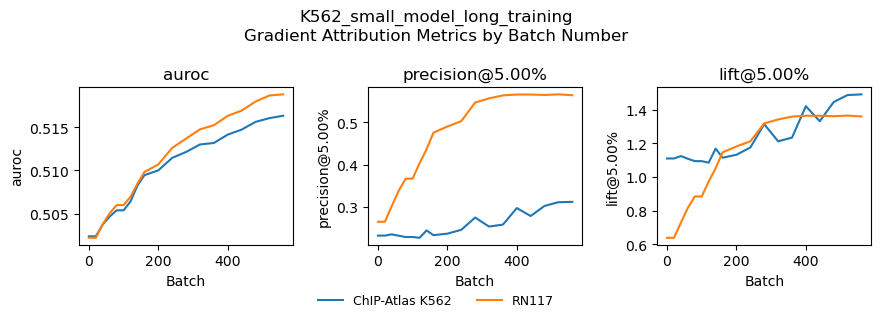

In [38]:
# Plot the precision@1.00% vs Batch for Gradient Attribution
import seaborn as sns
import matplotlib.pyplot as plt

method = "Gradient Attribution"
x="Batch"
y = ["auroc", "precision@5.00%", "lift@5.00%"]
hue="gt"

df = batch_results_df

plot_df = df[df["method"] == method]

fig, ax = plt.subplots(nrows=1, ncols=len(y), figsize=((3*len(y)), 3), sharex=True)
for i, y_col in enumerate(y):
    sns.lineplot(x=x, y=y_col, hue=hue, data=plot_df, ax=ax[i])
    ax[i].set_title(f"{y_col}")
    ax[i].set_xlabel(x)
    ax[i].set_ylabel(y_col)
    
plt.suptitle(f"{exp.experiment_name}\n{method} Metrics by {x} Number", fontsize=12)
plt.tight_layout()

handles, labels = ax[0].get_legend_handles_labels()
for a in ax:
    leg = a.get_legend()
    if leg is not None:
        leg.remove()

fig.legend(
    handles, labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=min(len(labels), 4),
    frameon=False,
    fontsize=9
)

plt.show()

In [39]:
if method == "Gradient Attribution":
    grad_attrib_batch_dir = exp.model_training_dir / "tf_tg_grad_attribution_batches"
elif method == "TF Knockout":
    batch_dir = exp.model_training_dir / "tf_knockout_batches"
else:
    raise ValueError(f"Unknown method: {method}")

batch_files = sorted(grad_attrib_batch_dir.glob("*.npy"))
batch_df_list = {}
for i, batch_file in enumerate(batch_files):
    batch_num = int(batch_file.stem.split("_")[-1])
    print(f"Loading Batch {batch_num}: {batch_file.stem} ({i+1}/{len(batch_files)})")
    
    batch_np = np.load(batch_file)

    batch_grad_df = format_grad_attrib_grn(batch_np, exp.tf_names, exp.tg_names)
    batch_grad_df = batch_grad_df.pivot(index="Source", columns="Target", values="Score")
    batch_df_list[batch_num] = batch_grad_df

batch_df_list.keys()

Loading Batch 0: tf_tg_grad_attribution_batch_0 (1/19)
Loading Batch 100: tf_tg_grad_attribution_batch_100 (2/19)
Loading Batch 120: tf_tg_grad_attribution_batch_120 (3/19)
Loading Batch 140: tf_tg_grad_attribution_batch_140 (4/19)
Loading Batch 160: tf_tg_grad_attribution_batch_160 (5/19)
Loading Batch 20: tf_tg_grad_attribution_batch_20 (6/19)
Loading Batch 200: tf_tg_grad_attribution_batch_200 (7/19)
Loading Batch 240: tf_tg_grad_attribution_batch_240 (8/19)
Loading Batch 280: tf_tg_grad_attribution_batch_280 (9/19)
Loading Batch 320: tf_tg_grad_attribution_batch_320 (10/19)
Loading Batch 360: tf_tg_grad_attribution_batch_360 (11/19)
Loading Batch 40: tf_tg_grad_attribution_batch_40 (12/19)
Loading Batch 400: tf_tg_grad_attribution_batch_400 (13/19)
Loading Batch 440: tf_tg_grad_attribution_batch_440 (14/19)
Loading Batch 480: tf_tg_grad_attribution_batch_480 (15/19)
Loading Batch 520: tf_tg_grad_attribution_batch_520 (16/19)
Loading Batch 560: tf_tg_grad_attribution_batch_560 (17/1

dict_keys([0, 100, 120, 140, 160, 20, 200, 240, 280, 320, 360, 40, 400, 440, 480, 520, 560, 60, 80])

In [111]:
batches = sorted(batch_df_list.keys())
selected_batch_num = batches[0]
df = batch_df_list[selected_batch_num]

df = df.melt(ignore_index=False, var_name="Target", value_name="Score").reset_index().rename(columns={"index": "Source"})

array([[<Axes: title={'center': 'Score'}>]], dtype=object)

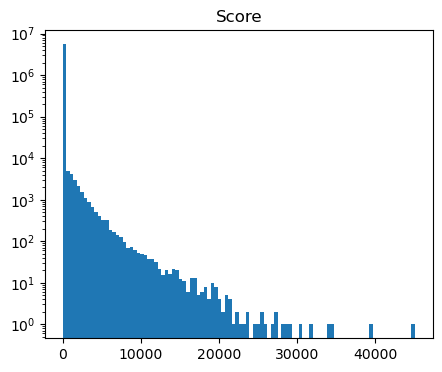

In [112]:
df.hist(column="Score", bins=100, grid=False, figsize=(5, 4), log=True)

In [ ]:
print()

count    5.544786e+06
mean     9.249944e+00
std      2.138812e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.511891e+04
Name: Score, dtype: float64


/tmp/ipykernel_826739/1917293730.py:32: RuntimeWarning: divide by zero encountered in log10
  score_log = np.log10(np.log1p(score_z))      # always finite


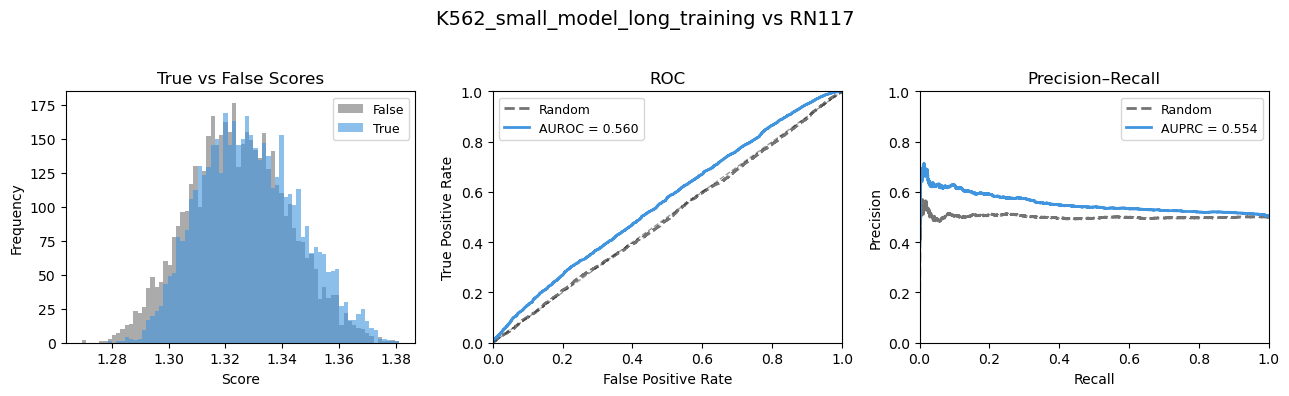

In [146]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve


def normalize_batch_df(batch_num):
    df = batch_df_list[batch_num]

    df = df.melt(ignore_index=False, var_name="Target", value_name="Score").reset_index().rename(columns={"index": "Source"})
    
    df = df[df["Score"] != 0].dropna()

    z = (df["Score"] - df["Score"].mean()) / (df["Score"].std() + 1e-12)
    
    log1pz = np.log1p(z)

    df["Score"] = np.log10(log1pz)

    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Score"])

    return df

def robust_normalize_df(batch_num):
    score = batch_df_list[batch_num]
    score = np.nan_to_num(score, nan=0.0)

    score_abs = np.abs(score)

    median_val = np.median(score_abs, axis=1, keepdims=True)
    mad = np.median(np.abs(score_abs - median_val), axis=1, keepdims=True) + 1e-6

    score_z = (score_abs - median_val) / mad
    score_z = np.clip(score_z, 0, None)          # ensure >= 0
    score_log = np.log10(np.log1p(score_z))      # always finite

    # score_log = np.nan_to_num(score_log, nan=0.0, posinf=0.0, neginf=0.0)

    T, G = score_log.shape
    tf_idx = np.repeat(np.arange(T), G)
    tg_idx = np.tile(np.arange(G), T)

    df = pd.DataFrame({
        "Source": np.asarray(exp.tf_names, dtype=object)[tf_idx],
        "Target": np.asarray(exp.tg_names, dtype=object)[tg_idx],
        "Score": score_log.ravel(),
    })

    df = df[df["Score"] > 0]

    return df

def normalize_no_scale_df(batch_num):
    score = batch_df_list[batch_num]
    score = np.nan_to_num(score, nan=0.0)

    score_abs = np.abs(score)

    median_val = np.median(score_abs, axis=1, keepdims=True)
    mad = np.median(np.abs(score_abs - median_val), axis=1, keepdims=True) + 1e-6

    score_z = (score_abs - median_val) / mad
    score_z = np.clip(score_z, 0, None)          # ensure >= 0
    # score_log = np.log10(np.log1p(score_z))      # always finite

    # score_log = np.nan_to_num(score_log, nan=0.0, posinf=0.0, neginf=0.0)

    T, G = score_z.shape
    tf_idx = np.repeat(np.arange(T), G)
    tg_idx = np.tile(np.arange(G), T)

    df = pd.DataFrame({
        "Source": np.asarray(exp.tf_names, dtype=object)[tf_idx],
        "Target": np.asarray(exp.tg_names, dtype=object)[tg_idx],
        "Score": score_z.ravel(),
    })

    # df = df[df["Score"] > 0]

    return df

def create_ground_truth_comparison_df(score_df, ground_truth_lookup, ground_truth_name):
    # Normalize once
    gt_tfs, gt_tgs, gt_pairs_set = ground_truth_lookup

    src = score_df["Source"]
    tgt = score_df["Target"]

    mask = src.isin(gt_tfs) & tgt.isin(gt_tgs)

    df = score_df.loc[mask].copy()
    # re-use normalized versions so we don't upper twice
    df["Source"] = src.loc[mask].values
    df["Target"] = tgt.loc[mask].values

    key = df["Source"] + "\t" + df["Target"]
    df["_in_gt"] = key.isin(gt_pairs_set).astype("int8")
    df["ground_truth_name"] = ground_truth_name

    return df

def plot_hist_roc_pr(labeled_df, exp, ground_truth_name, n_bins=75, random_state=42):
    # --- balance pos/neg once so all three panels use same data ---
    balanced = exp._balance_pos_neg(labeled_df, random_state=random_state).copy()

    # safety: remove NaN/inf scores
    balanced = balanced[np.isfinite(balanced["Score"].to_numpy())].copy()

    if balanced["_in_gt"].nunique() < 2:
        raise ValueError("Need both positive and negative examples to plot ROC/PR.")

    y = balanced["_in_gt"].astype(int).to_numpy()
    s = balanced["Score"].to_numpy()

    # --- ROC/PR metrics and curves ---
    auroc = roc_auc_score(y, s)
    fpr, tpr, _ = roc_curve(y, s)
    rand_fpr, rand_tpr, _ = roc_curve(y, exp._create_random_distribution(s))

    auprc = average_precision_score(y, s)
    prec, rec, _ = precision_recall_curve(y, s)
    rand_prec, rand_rec, _ = precision_recall_curve(y, exp._create_random_distribution(s))

    # --- Histogram data (balanced counts already, but keep code explicit) ---
    true_vals = balanced.loc[balanced["_in_gt"] == 1, "Score"].dropna()
    false_vals = balanced.loc[balanced["_in_gt"] == 0, "Score"].dropna()

    min_len = min(len(true_vals), len(false_vals))
    if min_len == 0:
        raise ValueError("Not enough positives/negatives to plot histograms.")

    true_vals = true_vals.sample(n=min_len, random_state=random_state)
    false_vals = false_vals.sample(n=min_len, random_state=random_state)

    combined = pd.concat([true_vals, false_vals])
    bins = np.linspace(combined.min(), combined.max(), n_bins)

    fig, ax = plt.subplots(1, 3, figsize=(13, 4))

    # (1) Histogram
    ax[0].hist(false_vals, bins=bins, alpha=0.6, color="#747474", label="False")
    ax[0].hist(true_vals,  bins=bins, alpha=0.6, color="#4195df", label="True")
    ax[0].set_title("True vs False Scores")
    ax[0].set_xlabel("Score")
    ax[0].set_ylabel("Frequency")
    ax[0].legend(fontsize=9)

    # (2) ROC
    ax[1].plot(rand_fpr, rand_tpr, color="#747474", linestyle="--", lw=2, label="Random")
    ax[1].plot(fpr, tpr, color="#4195df", lw=2, label=f"AUROC = {auroc:.3f}")
    ax[1].plot([0, 1], [0, 1], "k--", lw=1, alpha=0.4)
    ax[1].set_title("ROC")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_xlim(0, 1)
    ax[1].set_ylim(0, 1)
    ax[1].legend(fontsize=9)

    # (3) PR
    ax[2].plot(rand_rec, rand_prec, color="#747474", linestyle="--", lw=2, label="Random")
    ax[2].plot(rec, prec, color="#4195df", lw=2, label=f"AUPRC = {auprc:.3f}")
    ax[2].set_title("Precision–Recall")
    ax[2].set_xlabel("Recall")
    ax[2].set_ylabel("Precision")
    ax[2].set_xlim(0, 1)
    ax[2].set_ylim(0, 1)
    ax[2].legend(fontsize=9)

    fig.suptitle(f"{exp.experiment_name} vs {ground_truth_name}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    return fig

sample_type = exp.experiment_name.split("_")[0]
ground_truth_name = "RN117"

gt_df = gt_by_dataset_dict[sample_type][ground_truth_name]

batches = sorted(batch_df_list.keys())
selected_batch_num = batches[6]

df = robust_normalize_df(selected_batch_num)    
# df = normalize_no_scale_df(selected_batch_num)
df = create_ground_truth_comparison_df(df, gt_df[1], ground_truth_name)
fig = plot_hist_roc_pr(df, exp, ground_truth_name)
fig.show()


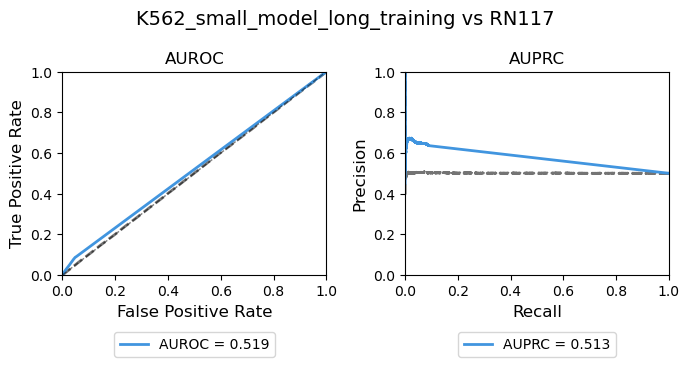

In [145]:
score_df = exp.load_grn("Gradient Attribution")
fig, overview_df = exp.plot_auroc_auprc(score_df, gt_df, ground_truth_name)
fig.show()

Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1500x1200 -pix_fmt rgba -framerate 2 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/K562_small_model_long_training/model_training_003/tf_tg_gradient_attribution_by_batch_number_heatmap.mp4


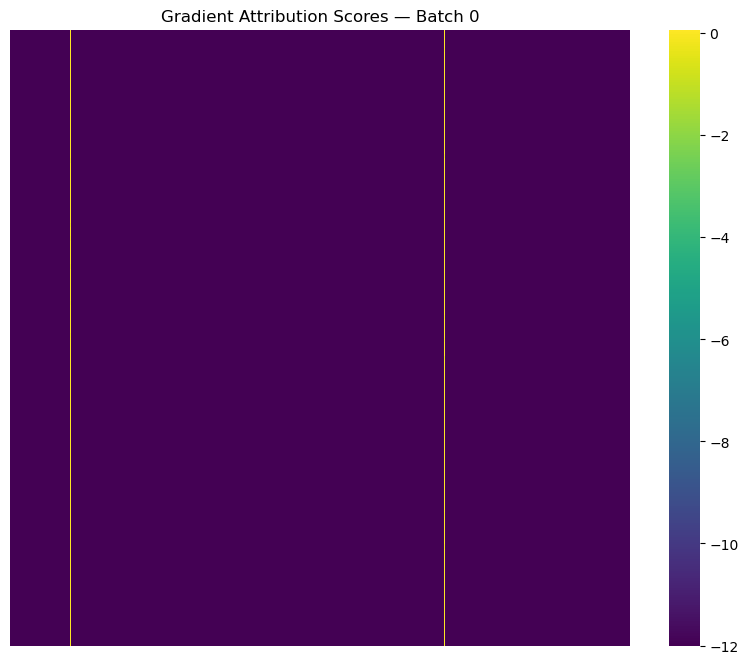

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

# Precompute frame order once
batches = sorted(batch_df_list.keys())

def make_dense(batch_num):
    df = batch_df_list[batch_num]

    # long -> normalize -> pivot (your logic)
    df = (
        df.melt(ignore_index=False, var_name="Target", value_name="Score")
          .reset_index()
          .rename(columns={"index": "Source"})
    )

    z = (df["Score"] - df["Score"].mean()) / (df["Score"].std() + 1e-12)

    # ensure log1p input > -1
    z = np.clip(z, -0.999999, None)

    # ensure log10 input > 0
    log1pz = np.log1p(z)
    log1pz = np.clip(log1pz, 1e-12, None)

    df["Score"] = np.log10(log1pz)

    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Score"])
    df_dense = df.pivot(index="Source", columns="Target", values="Score")

    return df_dense

# --- Pick a fixed set/order of rows/cols so the heatmap shape never changes ---
# Use the last batch (or union across batches if you prefer)
df0 = make_dense(batches[0])

# If you want fixed axes across all frames, define explicit row/col order:
row_order = df0.index
col_order = df0.columns

def dense_as_matrix(batch_num):
    d = make_dense(batch_num).reindex(index=row_order, columns=col_order)
    return d.to_numpy()

# Optional: set global color scale so colors are comparable across frames
# (recommended; otherwise colors re-scale visually if you redraw)
all_vals = []
for b in batches:
    M = dense_as_matrix(b)
    all_vals.append(M[np.isfinite(M)])
all_vals = np.concatenate(all_vals) if len(all_vals) else np.array([0.0])

vmin, vmax = np.nanpercentile(all_vals, [1, 99])  # robust scaling

# --- Draw initial frame ---
fig, ax = plt.subplots(figsize=(10, 8))

M0 = dense_as_matrix(batches[0])
hm = sns.heatmap(
    M0,
    ax=ax,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    cbar=True,
    xticklabels=False,
    yticklabels=False,
)

title = ax.set_title(f"{method} Scores — Batch {batches[0]}")

# Grab the QuadMesh (the colored cells) that seaborn created
quadmesh = ax.collections[0]

def update(frame_idx):
    batch_num = batches[frame_idx]
    M = dense_as_matrix(batch_num)

    # Update the heatmap cell colors
    quadmesh.set_array(M.ravel())

    # Update title
    title.set_text(f"{method} Scores — Batch {batch_num}")

    return (quadmesh, title)

anim = FuncAnimation(
    fig,
    update,
    frames=len(batches),
    interval=500,   # ms
    blit=False      # blit can be flaky with seaborn; False is safer
)

method_safe = method.replace(" ", "_").lower()
anim.save(exp.model_training_dir / f"tf_tg_{method_safe}_by_batch_number_heatmap.mp4", fps=2, dpi=150)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

# Precompute frame order once
batches = sorted(batch_df_list.keys())

def make_dense(batch_num):
    df = batch_df_list[batch_num]

    # long -> normalize -> pivot (your logic)
    df = (
        df.melt(ignore_index=False, var_name="Target", value_name="Score")
          .reset_index()
          .rename(columns={"index": "Source"})
    )

    z = (df["Score"] - df["Score"].mean()) / (df["Score"].std() + 1e-12)

    # ensure log1p input > -1
    z = np.clip(z, -0.999999, None)

    # ensure log10 input > 0
    log1pz = np.log1p(z)
    log1pz = np.clip(log1pz, 1e-12, None)

    df["Score"] = np.log10(log1pz)

    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Score"])
    df_dense = df.pivot(index="Source", columns="Target", values="Score")

    return df_dense

# --- Pick a fixed set/order of rows/cols so the heatmap shape never changes ---
# Use the last batch (or union across batches if you prefer)
df0 = make_dense(batches[0])

# If you want fixed axes across all frames, define explicit row/col order:
row_order = df0.index
col_order = df0.columns

def dense_as_matrix(batch_num):
    d = make_dense(batch_num).reindex(index=row_order, columns=col_order)
    return d.to_numpy()

# Optional: set global color scale so colors are comparable across frames
# (recommended; otherwise colors re-scale visually if you redraw)
all_vals = []
for b in batches:
    M = dense_as_matrix(b)
    all_vals.append(M[np.isfinite(M)])
all_vals = np.concatenate(all_vals) if len(all_vals) else np.array([0.0])

vmin, vmax = np.nanpercentile(all_vals, [1, 99])  # robust scaling

# --- Draw initial frame ---
fig, ax = plt.subplots(figsize=(10, 8))

M0 = dense_as_matrix(batches[0])
hm = sns.heatmap(
    M0,
    ax=ax,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    cbar=True,
    xticklabels=False,
    yticklabels=False,
)

title = ax.set_title(f"{method} Scores — Batch {batches[0]}")

# Grab the QuadMesh (the colored cells) that seaborn created
quadmesh = ax.collections[0]

def update(frame_idx):
    batch_num = batches[frame_idx]
    M = dense_as_matrix(batch_num)

    # Update the heatmap cell colors
    quadmesh.set_array(M.ravel())

    # Update title
    title.set_text(f"{method} Scores — Batch {batch_num}")

    return (quadmesh, title)

anim = FuncAnimation(
    fig,
    update,
    frames=len(batches),
    interval=500,   # ms
    blit=False      # blit can be flaky with seaborn; False is safer
)


plt.show()

Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1500x1200 -pix_fmt rgba -framerate 2 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y heatmap.mp4
/gpfs/Home/esm5360/miniconda3/envs/my_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/gpfs/Home/esm5360/miniconda3/envs/my_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/gpfs/Home/esm5360/miniconda3/envs/my_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/gpfs/Home/esm5360/miniconda3/envs/my_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encounte

## Formatting and Plotting the Results

In [125]:
# tf_ko_by_batch = final_grn_df[final_grn_df["method"] == "TF Knockout"].groupby(["Batch", "checkpoint_name", "KO_Mode"])[["auroc", "auprc"]].mean().reset_index().sort_values("Batch")
grad_attr_by_batch = final_grn_df[final_grn_df["method"] == "Gradient Attribution"].groupby(["Batch", "checkpoint_name"])[["auroc", "auprc"]].mean().reset_index().sort_values("Batch")

auroc_result_dict = {
    # "TF Knockout": tf_ko_by_batch[["Batch", "checkpoint_name", "KO_Mode", "auroc"]],
    "Gradient Attribution": grad_attr_by_batch[["Batch", "checkpoint_name", "auroc"]],
}

In [62]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150

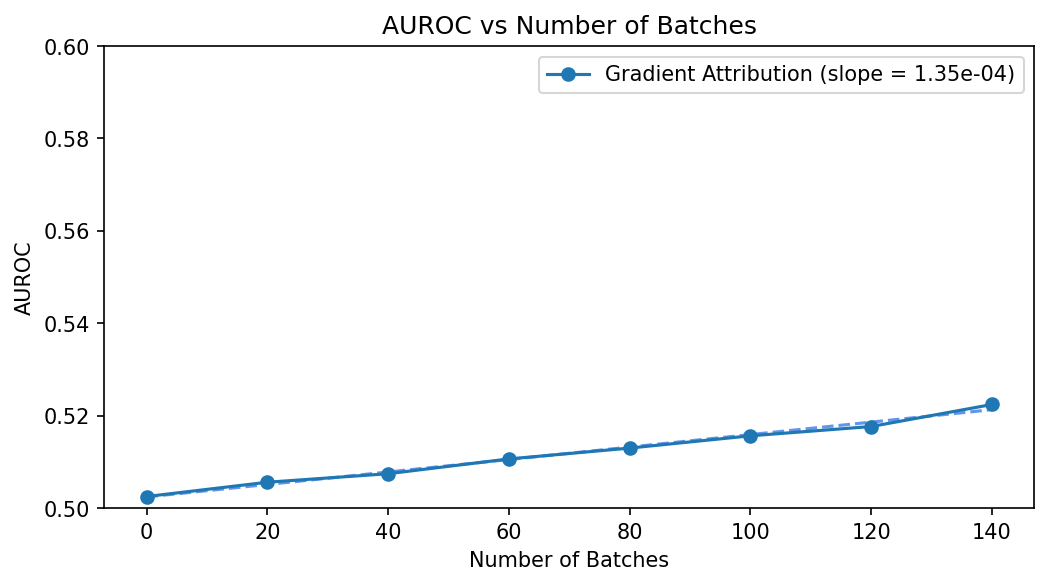

In [128]:
from scipy import stats

# selected_mode = "scaled_k_sigma"

def calculate_slope(df):
    x_data = df["Batch"].to_numpy()
    y_data = df["auroc"].to_numpy()

    slope, intercept, r, p, se = stats.linregress(x_data, y_data)

    x = np.linspace(x_data.min(), x_data.max(), 200)
    y = slope * x + intercept
    
    return x, y, slope

plt.figure(figsize=(8,4))

grad_attr_df = auroc_result_dict["Gradient Attribution"]
# tf_ko_df = auroc_result_dict["TF Knockout"]
# tf_ko_df = tf_ko_df[tf_ko_df["KO_Mode"] == selected_mode]

grad_attr_x, grad_attr_y, grad_attr_slope = calculate_slope(grad_attr_df)
# tf_ko_x, tf_ko_y, tf_ko_slope = calculate_slope(tf_ko_df)

plt.plot(grad_attr_x, grad_attr_y, color="cornflowerblue", linestyle="--")
# plt.plot(tf_ko_x, tf_ko_y, color="orange", linestyle="--")

for checkpoint_name in checkpoints:
    grad_attr_subset = grad_attr_df[grad_attr_df["checkpoint_name"] == checkpoint_name]
    # tf_ko_subset = tf_ko_df[tf_ko_df["checkpoint_name"] == checkpoint_name]
    plt.plot(grad_attr_subset["Batch"], grad_attr_subset["auroc"], label=f"Gradient Attribution (slope = {grad_attr_slope:.2e})", marker="o")
    # plt.plot(tf_ko_subset["Batch"], tf_ko_subset["auroc"], label=f"TF Knockout (slope = {tf_ko_slope:.2e})", marker="o", linestyle="dashed")

plt.xlabel("Number of Batches")
plt.ylabel("AUROC")
plt.xticks(grad_attr_df["Batch"].unique())
plt.ylim(0.5, 0.6)
plt.legend()
plt.title(f"AUROC vs Number of Batches")
plt.show()


In [88]:
# Ensure that the trained and untrained models have different parameters (sanity check)
def param_fingerprint(model):
    with torch.no_grad():
        p = next(model.parameters()).detach().float().cpu()
    return float(p.mean()), float(p.std())

print("Parameter fingerprints (mean, std) for loaded checkpoints:")
for ckpt in ["checkpoint_0.pt","trained_model.pt"]:
    exp.load_trained_model(ckpt)
    print(f"  - {ckpt} {param_fingerprint(exp.model)}")


Parameter fingerprints (mean, std) for loaded checkpoints:
  - checkpoint_0.pt (-0.007206522859632969, 1.0109975337982178)
  - trained_model.pt (-0.006401196122169495, 1.0115910768508911)


In [89]:
ga0 = grad_attrib_dfs["checkpoint_0.pt"]["Score"].to_numpy()
ga1 = grad_attrib_dfs["trained_model.pt"]["Score"].to_numpy()
print("Gradient Attribution differences between checkpoints:")
print("  - score corr:", np.corrcoef(ga0, ga1)[0,1])
print("  - mean abs diff:", np.mean(np.abs(ga0 - ga1)))

for ko_mode in ["raw_zero", "raw_percentile", "scaled_k_sigma"]:
    tfko0 = tf_ko_dfs["checkpoint_0.pt"][ko_mode]["Score"].to_numpy()
    tfko1 = tf_ko_dfs["trained_model.pt"][ko_mode]["Score"].to_numpy()
    print(f"\nTF Knockout differences for mode '{ko_mode}' between checkpoints:")
    print("  - score corr:", np.corrcoef(tfko0, tfko1)[0,1])
    print("  - mean abs diff:", np.mean(np.abs(tfko0 - tfko1)))



Gradient Attribution differences between checkpoints:
  - score corr: 0.18826708511253593
  - mean abs diff: 0.00041256362

TF Knockout differences for mode 'raw_zero' between checkpoints:
  - score corr: nan
  - mean abs diff: 0.0

TF Knockout differences for mode 'raw_percentile' between checkpoints:
  - score corr: 0.11032474539842768
  - mean abs diff: 8.053749338495201e-05

TF Knockout differences for mode 'scaled_k_sigma' between checkpoints:
  - score corr: 0.11710114764598735
  - mean abs diff: 0.0001149580067646866


/gpfs/Home/esm5360/miniconda3/envs/my_env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


In [90]:
for ko_mode in ["raw_zero", "raw_percentile", "scaled_k_sigma"]:
    tfko0 = tf_ko_dfs["checkpoint_0.pt"][ko_mode]["Score"].to_numpy()
    tfko1 = tf_ko_dfs["trained_model.pt"][ko_mode]["Score"].to_numpy()
    print(f"\nTF Knockout differences for mode '{ko_mode}' between checkpoints:")
    print("  - TFKO % exactly 0 (ckpt0):", (tfko0 == 0).mean())
    print("  - TFKO % exactly 0 (trained):", (tfko1 == 0).mean())
    print("  - TFKO p99:", np.quantile(tfko1, 0.99))
    print("  - TFKO max:", tfko1.max())



TF Knockout differences for mode 'raw_zero' between checkpoints:
  - TFKO % exactly 0 (ckpt0): 1.0
  - TFKO % exactly 0 (trained): 1.0
  - TFKO p99: 0.0
  - TFKO max: 0.0

TF Knockout differences for mode 'raw_percentile' between checkpoints:
  - TFKO % exactly 0 (ckpt0): 0.9786803313960178
  - TFKO % exactly 0 (trained): 0.9798095003125459
  - TFKO p99: 0.00012108414375676923
  - TFKO max: 0.8015046119681926

TF Knockout differences for mode 'scaled_k_sigma' between checkpoints:
  - TFKO % exactly 0 (ckpt0): 0.9785937635825801
  - TFKO % exactly 0 (trained): 0.9799151851847844
  - TFKO p99: 0.000220346709101947
  - TFKO max: 0.950663745402339


## Compare the TG prediction MSE when TF expression is zeroed

In [74]:
import torch
import numpy as np
from tqdm import tqdm

@torch.no_grad()
def compare_tf_on_off(
    model,
    test_loader,
    tg_scaler,
    tf_scaler,
    device,
    use_amp=False,
    max_batches=50,
    tf_off_mode="raw_zero",   # "raw_zero" or "scaled_zero"
    disable_bias=True,
    disable_motif_mask=True,
    disable_shortcut=True,
):
    model.eval().to(device)

    # Optional: disable architecture priors for fairness
    old_use_bias = getattr(model, "use_bias", None)
    old_use_motif = getattr(model, "use_motif_mask", None)
    old_shortcut_scale = None

    if disable_bias and old_use_bias is not None:
        model.use_bias = False
    if disable_motif_mask and old_use_motif is not None:
        model.use_motif_mask = False
        if hasattr(model, "shortcut_layer"):
            model.shortcut_layer.use_motif_mask = False
    if disable_shortcut and hasattr(model, "shortcut_layer"):
        old_shortcut_scale = model.shortcut_layer.scale.detach().clone()
        model.shortcut_layer.scale.data.zero_()

    mse_on, mse_off = [], []
    delta_mean_abs = []

    it = tqdm(test_loader, total=max_batches, desc="TF on vs off", ncols=100)
    for b_idx, batch in enumerate(it):
        if max_batches is not None and b_idx >= max_batches:
            break

        atac_wins, tf_tensor, targets, bias, tf_ids, tg_ids, motif_mask = batch
        atac_wins = atac_wins.to(device, non_blocking=True)
        tf_tensor = tf_tensor.to(device, non_blocking=True)
        targets   = targets.to(device, non_blocking=True)
        tf_ids    = tf_ids.to(device, non_blocking=True)
        tg_ids    = tg_ids.to(device, non_blocking=True)

        # call-time disable
        if disable_bias:
            bias = None
        else:
            bias = bias.to(device, non_blocking=True) if bias is not None else None

        if disable_motif_mask:
            motif_mask = None
        else:
            motif_mask = motif_mask.to(device, non_blocking=True) if motif_mask is not None else None

        # ---- TF ON ----
        tf_scaled_on = tf_scaler.transform(tf_tensor, tf_ids) if tf_scaler is not None else tf_tensor
        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            pred_on_s, _, _ = model(
                atac_wins, tf_scaled_on,
                tf_ids=tf_ids, tg_ids=tg_ids,
                bias=bias, motif_mask=motif_mask,
                return_shortcut_contrib=False,
            )
        pred_on = tg_scaler.inverse_transform(pred_on_s, tg_ids) if tg_scaler is not None else pred_on_s
        pred_on = torch.nan_to_num(pred_on.float(), nan=0.0, posinf=1e6, neginf=-1e6)

        # ---- TF OFF ----
        if tf_off_mode == "raw_zero":
            tf_off = tf_tensor.clone()
            if tf_off.dim() == 2:
                tf_off.zero_()
            else:
                tf_off[..., 0].zero_()
            tf_scaled_off = tf_scaler.transform(tf_off, tf_ids) if tf_scaler is not None else tf_off
        elif tf_off_mode == "scaled_zero":
            tf_scaled_off = torch.zeros_like(tf_scaled_on)
        else:
            raise ValueError("tf_off_mode must be 'raw_zero' or 'scaled_zero'")

        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            pred_off_s, _, _ = model(
                atac_wins, tf_scaled_off,
                tf_ids=tf_ids, tg_ids=tg_ids,
                bias=bias, motif_mask=motif_mask,
                return_shortcut_contrib=False,
            )
        pred_off = tg_scaler.inverse_transform(pred_off_s, tg_ids) if tg_scaler is not None else pred_off_s
        pred_off = torch.nan_to_num(pred_off.float(), nan=0.0, posinf=1e6, neginf=-1e6)

        # ---- Metrics ----
        # MSE in unscaled TG space (what you probably want for interpretability)
        mse_on.append(torch.mean((pred_on - targets)**2).item())
        mse_off.append(torch.mean((pred_off - targets)**2).item())

        # average absolute change in predictions
        delta_mean_abs.append(torch.mean(torch.abs(pred_on - pred_off)).item())

    # restore model flags
    if old_use_bias is not None:
        model.use_bias = old_use_bias
    if old_use_motif is not None:
        model.use_motif_mask = old_use_motif
    if old_shortcut_scale is not None and hasattr(model, "shortcut_layer"):
        model.shortcut_layer.scale.data.copy_(old_shortcut_scale)

    out = {
        "mse_on_mean": float(np.mean(mse_on)),
        "mse_off_mean": float(np.mean(mse_off)),
        "mse_off_minus_on": float(np.mean(mse_off) - np.mean(mse_on)),
        "delta_pred_mean_abs": float(np.mean(delta_mean_abs)),
        "n_batches": len(mse_on),
        "tf_off_mode": tf_off_mode,
    }
    return out

for checkpoint_name in checkpoints:
    print(f"\nComparing TF ON vs OFF for checkpoint: {checkpoint_name}")
    exp.load_trained_model(checkpoint_name)
    res = compare_tf_on_off(
        model=exp.model,
        test_loader=exp.test_loader,
        tg_scaler=exp.tg_scaler,
        tf_scaler=exp.tf_scaler,
        device=exp.device,
        use_amp=False,
        max_batches=50,
        tf_off_mode="raw_zero",
        disable_bias=True,
        disable_motif_mask=True,
        disable_shortcut=True,
    )
    for key, value in res.items():
        print(f"  - {key}: {value}")




Comparing TF ON vs OFF for checkpoint: checkpoint_0.pt


TF on vs off:  44%|█████████████████████▌                           | 22/50 [00:00<00:01, 23.65it/s]


  - mse_on_mean: 1.5179482725533573
  - mse_off_mean: 1.5164991508830676
  - mse_off_minus_on: -0.0014491216702896548
  - delta_pred_mean_abs: 0.01273659070615064
  - n_batches: 22
  - tf_off_mode: raw_zero

Comparing TF ON vs OFF for checkpoint: trained_model.pt


TF on vs off:  44%|█████████████████████▌                           | 22/50 [00:00<00:01, 25.75it/s]

  - mse_on_mean: 0.014005149280737069
  - mse_off_mean: 0.02706064588644288
  - mse_off_minus_on: 0.01305549660570581
  - delta_pred_mean_abs: 0.07132863338020715
  - n_batches: 22
  - tf_off_mode: raw_zero


In [121]:
import numpy as np
import torch
from tqdm import tqdm

@torch.no_grad()
def per_tf_knockout_sensitivity(
    model,
    test_loader,
    tg_scaler,
    tf_scaler,
    device,
    use_amp=False,
    max_batches=25,          # start smaller, then increase
    tf_off_mode="raw_zero",  # "raw_zero" or "scaled_zero"
    disable_bias=True,
    disable_motif_mask=True,
    disable_shortcut=True,
    eps_skip=1e-8,           # skip TF positions that are ~0 already
):
    model.eval().to(device)

    # Disable priors safely (save+restore)
    old_use_bias = getattr(model, "use_bias", None)
    old_use_motif = getattr(model, "use_motif_mask", None)
    old_shortcut_scale = None

    if disable_bias and old_use_bias is not None:
        model.use_bias = False
    if disable_motif_mask and old_use_motif is not None:
        model.use_motif_mask = False
        if hasattr(model, "shortcut_layer"):
            model.shortcut_layer.use_motif_mask = False
    if disable_shortcut and hasattr(model, "shortcut_layer"):
        old_shortcut_scale = model.shortcut_layer.scale.detach().clone()
        model.shortcut_layer.scale.data.zero_()

    # Accumulators over global TF vocab id
    # We'll accumulate mean ΔMSE over batches where that TF appears in tf_ids
    tf_vocab_size = None
    # We'll infer tf_vocab_size from scaler if possible
    if tf_scaler is not None and hasattr(tf_scaler, "mean"):
        tf_vocab_size = int(tf_scaler.mean.numel())
    else:
        # fallback: track max tf_id seen
        tf_vocab_size = 0

    delta_sum = None
    delta_cnt = None

    it = tqdm(test_loader, total=max_batches, desc="Per-TF KO sensitivity")

    for b_idx, batch in enumerate(it):
        if max_batches is not None and b_idx >= max_batches:
            break

        atac_wins, tf_tensor, targets, bias, tf_ids, tg_ids, motif_mask = batch
        atac_wins = atac_wins.to(device, non_blocking=True)
        tf_tensor = tf_tensor.to(device, non_blocking=True)   # unscaled
        targets   = targets.to(device, non_blocking=True)
        tf_ids    = tf_ids.to(device, non_blocking=True)
        tg_ids    = tg_ids.to(device, non_blocking=True)

        # call-time disable
        if disable_bias:
            bias = None
        else:
            bias = bias.to(device, non_blocking=True) if bias is not None else None
        if disable_motif_mask:
            motif_mask = None
        else:
            motif_mask = motif_mask.to(device, non_blocking=True) if motif_mask is not None else None

        # Shapes
        if tf_tensor.dim() == 2:
            B, T_eval = tf_tensor.shape
            F_dim = 1
            tf_expr = tf_tensor                    # [B, T]
        else:
            B, T_eval, F_dim = tf_tensor.shape
            tf_expr = tf_tensor[..., 0]            # [B, T]

        # Infer vocab size from tf_ids if needed
        max_id = int(tf_ids.max().item())
        if tf_vocab_size is None or tf_vocab_size == 0:
            tf_vocab_size = max_id + 1
        else:
            tf_vocab_size = max(tf_vocab_size, max_id + 1)

        if delta_sum is None:
            delta_sum = torch.zeros(tf_vocab_size, device="cpu", dtype=torch.float64)
            delta_cnt = torch.zeros(tf_vocab_size, device="cpu", dtype=torch.float64)
        elif tf_vocab_size > delta_sum.numel():
            # expand if we discovered higher ids
            new_sum = torch.zeros(tf_vocab_size, device="cpu", dtype=torch.float64)
            new_cnt = torch.zeros(tf_vocab_size, device="cpu", dtype=torch.float64)
            new_sum[: delta_sum.numel()] = delta_sum
            new_cnt[: delta_cnt.numel()] = delta_cnt
            delta_sum, delta_cnt = new_sum, new_cnt

        # ---- baseline preds ----
        tf_scaled_on = tf_scaler.transform(tf_tensor, tf_ids) if tf_scaler is not None else tf_tensor
        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            pred_on_s, _, _ = model(
                atac_wins, tf_scaled_on,
                tf_ids=tf_ids, tg_ids=tg_ids,
                bias=bias, motif_mask=motif_mask,
                return_shortcut_contrib=False,
            )
        pred_on = tg_scaler.inverse_transform(pred_on_s, tg_ids) if tg_scaler is not None else pred_on_s
        pred_on = torch.nan_to_num(pred_on.float(), nan=0.0, posinf=1e6, neginf=-1e6)
        mse_on = torch.mean((pred_on - targets) ** 2).item()

        # ---- per-position KO ----
        # We'll iterate TF positions within this batch’s evaluated TF list.
        for t_pos in range(T_eval):
            # skip if this TF has no expression anyway
            if torch.all(tf_expr[:, t_pos].abs() < eps_skip):
                continue

            # build tf_off
            if tf_off_mode == "raw_zero":
                tf_off = tf_tensor.clone()
                if tf_off.dim() == 2:
                    tf_off[:, t_pos] = 0.0
                else:
                    tf_off[:, t_pos, 0] = 0.0
            elif tf_off_mode == "scaled_zero":
                # compute on once, then only edit scaled input
                # (note: scaled_zero = set to mean)
                tf_off = None
            else:
                raise ValueError("tf_off_mode must be 'raw_zero' or 'scaled_zero'")

            if tf_off_mode == "raw_zero":
                tf_scaled_off = tf_scaler.transform(tf_off, tf_ids) if tf_scaler is not None else tf_off
            else:
                tf_scaled_off = tf_scaled_on.clone()
                # set scaled expression channel for that position to 0
                if tf_scaled_off.dim() == 2:
                    tf_scaled_off[:, t_pos] = 0.0
                else:
                    tf_scaled_off[:, t_pos, 0] = 0.0

            with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                pred_off_s, _, _ = model(
                    atac_wins, tf_scaled_off,
                    tf_ids=tf_ids, tg_ids=tg_ids,
                    bias=bias, motif_mask=motif_mask,
                    return_shortcut_contrib=False,
                )
            pred_off = tg_scaler.inverse_transform(pred_off_s, tg_ids) if tg_scaler is not None else pred_off_s
            pred_off = torch.nan_to_num(pred_off.float(), nan=0.0, posinf=1e6, neginf=-1e6)
            mse_off = torch.mean((pred_off - targets) ** 2).item()

            delta = float(mse_off - mse_on)

            tf_global = int(tf_ids[t_pos].item()) if tf_ids.dim() == 1 else int(tf_ids[0, t_pos].item())
            delta_sum[tf_global] += delta
            delta_cnt[tf_global] += 1.0

    # restore model flags
    if old_use_bias is not None:
        model.use_bias = old_use_bias
    if old_use_motif is not None:
        model.use_motif_mask = old_use_motif
    if old_shortcut_scale is not None and hasattr(model, "shortcut_layer"):
        model.shortcut_layer.scale.data.copy_(old_shortcut_scale)

    delta_mean = (delta_sum / (delta_cnt + 1e-12)).numpy()
    counts = delta_cnt.numpy()

    return delta_mean, counts

for ckpt in ["checkpoint_0.pt", "trained_model.pt"]:
    print(f"\nEvaluating per-TF knockout sensitivity for checkpoint: {ckpt}")
    exp.load_trained_model(ckpt)
    delta_mean, counts = per_tf_knockout_sensitivity(
        model=exp.model,
        test_loader=exp.test_loader,
        tg_scaler=exp.tg_scaler,
        tf_scaler=exp.tf_scaler,
        device=exp.device,
        use_amp=False,
        max_batches=22,
        tf_off_mode="raw_zero",
        disable_bias=True,
        disable_motif_mask=True,
        disable_shortcut=True,
    )
    
    print(f"  - {ckpt} overall mean ΔMSE: {np.nanmean(delta_mean[counts > 0])}")

    if ckpt == "trained_model.pt":
        delta_mean_trained = delta_mean.copy()
        counts_trained = counts.copy()
    
    valid = counts > 0
    d = delta_mean[valid]

    print(f"  - TFs evaluated: {valid.sum()}")
    print(f"  - median ΔMSE: {np.median(d):.2e}")
    print(f"  - 95th pct ΔMSE: {np.quantile(d, 0.95):.2e}")
    print(f"  - fraction ΔMSE > 0: {np.mean(d > 0):.3f}")
    top = np.argsort(d)[-10:][::-1]
    for tf_id in top:
        print(f" tf_id {tf_id}, name {exp.tf_names[tf_id]}, ΔMSE {d[tf_id]:.3e}")




Evaluating per-TF knockout sensitivity for checkpoint: checkpoint_0.pt


Per-TF KO sensitivity: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


  - checkpoint_0.pt overall mean ΔMSE: -8.842757469601277e-06
  - TFs evaluated: 134
  - median ΔMSE: -5.79e-06
  - 95th pct ΔMSE: 4.15e-06
  - fraction ΔMSE > 0: 0.142
 tf_id 11, name CREM, ΔMSE 2.328e-05
 tf_id 9, name CREB5, ΔMSE 1.163e-05
 tf_id 80, name TEAD1, ΔMSE 1.016e-05
 tf_id 69, name SKIL, ΔMSE 8.364e-06
 tf_id 104, name ZNF347, ΔMSE 7.600e-06
 tf_id 64, name PRDM10, ΔMSE 5.370e-06
 tf_id 56, name NR1D2, ΔMSE 4.660e-06
 tf_id 44, name MAX, ΔMSE 3.872e-06
 tf_id 129, name ZNF865, ΔMSE 3.866e-06
 tf_id 100, name ZNF280A, ΔMSE 3.503e-06

Evaluating per-TF knockout sensitivity for checkpoint: trained_model.pt


Per-TF KO sensitivity: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]

  - trained_model.pt overall mean ΔMSE: 6.0023861798850616e-05
  - TFs evaluated: 134
  - median ΔMSE: 4.69e-07
  - 95th pct ΔMSE: 1.95e-04
  - fraction ΔMSE > 0: 0.784
 tf_id 65, name RFX3, ΔMSE 3.283e-03
 tf_id 42, name LIN28B, ΔMSE 2.189e-03
 tf_id 52, name MYC, ΔMSE 6.466e-04
 tf_id 88, name ZEB1, ΔMSE 2.899e-04
 tf_id 122, name ZNF730, ΔMSE 2.802e-04
 tf_id 16, name EGR1, ΔMSE 2.171e-04
 tf_id 41, name LEF1, ΔMSE 1.953e-04
 tf_id 128, name ZNF846, ΔMSE 1.941e-04
 tf_id 43, name MAFG, ΔMSE 1.722e-04
 tf_id 7, name CGGBP1, ΔMSE 1.110e-04


## Do the important TFs (high ΔMSE) actually correspond to higher AUROC TFs?

In [141]:
df = checkpoint_per_tf_grn_df.copy()

ckpt_a = "checkpoint_0.pt"
ckpt_b = "trained_model.pt"

pivot = (
    df[df["checkpoint_name"].isin([ckpt_a, ckpt_b])]
    .pivot_table(
        index=["method", "gt", "tf"],
        columns="checkpoint_name",
        values="auroc",
        aggfunc="mean"
    )
    .reset_index()
)

pivot["delta_auroc"] = pivot[ckpt_b] - pivot[ckpt_a]
pivot.head()

checkpoint_name,method,gt,tf,checkpoint_0.pt,trained_model.pt,delta_auroc
0,Gradient Attribution,ChIP-Atlas K562,ATF3,0.518821,0.518835,0.000014
1,Gradient Attribution,ChIP-Atlas K562,BCL6,0.516574,0.516877,0.000303
2,Gradient Attribution,ChIP-Atlas K562,CGGBP1,0.514802,0.514672,-0.000131
3,Gradient Attribution,ChIP-Atlas K562,CREB3L1,0.522384,0.522397,0.000013
4,Gradient Attribution,ChIP-Atlas K562,CREB5,0.517024,0.517260,0.000236


In [142]:
summary = (
    pivot
    .groupby(["gt", "method"])
    .agg(
        n_tfs=("delta_auroc", "count"),
        mean_delta=("delta_auroc", "mean"),
        median_delta=("delta_auroc", "median"),
        frac_improved=("delta_auroc", lambda x: np.mean(x > 0)),
        frac_gt_001=("delta_auroc", lambda x: np.mean(x > 0.01)),
        frac_gt_002=("delta_auroc", lambda x: np.mean(x > 0.02)),
    )
    .reset_index()
    .sort_values(["gt", "median_delta"], ascending=[True, False])
)

summary


,gt,method,n_tfs,mean_delta,median_delta,frac_improved,frac_gt_001,frac_gt_002
1,ChIP-Atlas K562,TF Knockout Effect (raw_percentile),50,0.003876,0.005422,0.780000,0.060000,0.0
3,ChIP-Atlas K562,TF Knockout Effect (scaled_k_sigma),50,0.002766,0.003994,0.760000,0.020000,0.0
2,ChIP-Atlas K562,TF Knockout Effect (raw_zero),50,0.000028,0.000044,0.520000,0.000000,0.0
0,ChIP-Atlas K562,Gradient Attribution,50,0.000049,0.000019,0.660000,0.000000,0.0
5,RN117,TF Knockout Effect (raw_percentile),17,0.002612,0.004238,0.647059,0.117647,0.0
7,RN117,TF Knockout Effect (scaled_k_sigma),17,0.002001,0.003003,0.647059,0.000000,0.0
4,RN117,Gradient Attribution,17,-0.000009,-0.000051,0.352941,0.000000,0.0
6,RN117,TF Knockout Effect (raw_zero),17,-0.001662,-0.001642,0.352941,0.000000,0.0


In [143]:
top_tfs = (
    pivot
    .sort_values("delta_auroc", ascending=False)
    .groupby(["gt", "method"])
    .head(15)
)

top_tfs[["gt","method","tf","delta_auroc"]]


checkpoint_name,gt,method,tf,delta_auroc
128,RN117,TF Knockout Effect (raw_percentile),RUNX1,0.011516
120,RN117,TF Knockout Effect (raw_percentile),ETV6,0.010949
107,ChIP-Atlas K562,TF Knockout Effect (raw_percentile),ZNF12,0.010745
86,ChIP-Atlas K562,TF Knockout Effect (raw_percentile),KDM5B,0.010407
114,ChIP-Atlas K562,TF Knockout Effect (raw_percentile),ZNF449,0.010293
...,...,...,...,...
263,RN117,TF Knockout Effect (scaled_k_sigma),SOX6,-0.004356
192,RN117,TF Knockout Effect (raw_zero),MYC,-0.005063
127,RN117,TF Knockout Effect (raw_percentile),PRDM10,-0.005145
196,RN117,TF Knockout Effect (raw_zero),SOX6,-0.006764


In [144]:
delta_mse_df = pd.DataFrame({
    "tf": exp.tf_names,
    "delta_mse": delta_mean  # from your per_tf_knockout_sensitivity
})


In [145]:
merged = pivot.merge(delta_mse_df, on="tf", how="left")
print(merged.head())

                 method               gt       tf  checkpoint_0.pt  \
0  Gradient Attribution  ChIP-Atlas K562     ATF3         0.518821   
1  Gradient Attribution  ChIP-Atlas K562     BCL6         0.516574   
2  Gradient Attribution  ChIP-Atlas K562   CGGBP1         0.514802   
3  Gradient Attribution  ChIP-Atlas K562  CREB3L1         0.522384   
4  Gradient Attribution  ChIP-Atlas K562    CREB5         0.517024   

   trained_model.pt  delta_auroc     delta_mse  
0          0.518835     0.000014  4.473100e-06  
1          0.516877     0.000303  2.000227e-07  
2          0.514672    -0.000131  1.110194e-04  
3          0.522397     0.000013  2.593628e-06  
4          0.517260     0.000236  1.440375e-07  


In [146]:
var_check = (merged
    .groupby(["gt","method"])
    .agg(
        n=("delta_auroc","count"),
        delta_auroc_std=("delta_auroc","std"),
        delta_mse_std=("delta_mse","std"),
        delta_auroc_nunique=("delta_auroc","nunique"),
        auroc0_nunique=("checkpoint_0.pt","nunique"),
        auroc1_nunique=("trained_model.pt","nunique"),
    )
    .reset_index()
)

print(var_check)


                gt                               method   n  delta_auroc_std  \
0  ChIP-Atlas K562                 Gradient Attribution  50         0.000111   
1  ChIP-Atlas K562  TF Knockout Effect (raw_percentile)  50         0.004771   
2  ChIP-Atlas K562        TF Knockout Effect (raw_zero)  50         0.003623   
3  ChIP-Atlas K562  TF Knockout Effect (scaled_k_sigma)  50         0.004608   
4            RN117                 Gradient Attribution  17         0.000210   
5            RN117  TF Knockout Effect (raw_percentile)  17         0.006526   
6            RN117        TF Knockout Effect (raw_zero)  17         0.005042   
7            RN117  TF Knockout Effect (scaled_k_sigma)  17         0.005614   

   delta_mse_std  delta_auroc_nunique  auroc0_nunique  auroc1_nunique  
0       0.000101                   50              50              50  
1       0.000101                   50              50              50  
2       0.000101                   50              50          

In [147]:
corr_df = (
    merged
    .groupby(["gt", "method"])
    .apply(lambda g: g[["delta_mse", "delta_auroc"]]
           .dropna()
           .corr()
           .iloc[0,1])
    .reset_index(name="corr(delta_mse, delta_auroc)")
    .sort_values("corr(delta_mse, delta_auroc)", ascending=False)
)

print(corr_df)


                gt                               method  \
2  ChIP-Atlas K562        TF Knockout Effect (raw_zero)   
0  ChIP-Atlas K562                 Gradient Attribution   
6            RN117        TF Knockout Effect (raw_zero)   
4            RN117                 Gradient Attribution   
1  ChIP-Atlas K562  TF Knockout Effect (raw_percentile)   
3  ChIP-Atlas K562  TF Knockout Effect (scaled_k_sigma)   
5            RN117  TF Knockout Effect (raw_percentile)   
7            RN117  TF Knockout Effect (scaled_k_sigma)   

   corr(delta_mse, delta_auroc)  
2                     -0.128521  
0                     -0.159794  
6                     -0.220839  
4                     -0.299145  
1                     -0.411431  
3                     -0.412405  
5                     -0.492854  
7                     -0.650137  


/tmp/ipykernel_36461/1783682921.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[["delta_mse", "delta_auroc"]]


In [148]:
# build pivot for auprc, same as auroc
pivot_pr = (
    checkpoint_per_tf_grn_df[checkpoint_per_tf_grn_df["checkpoint_name"].isin(["checkpoint_0.pt","trained_model.pt"])]
    .pivot_table(index=["gt","method","tf"], columns="checkpoint_name", values="auprc", aggfunc="mean")
    .reset_index()
)
pivot_pr["delta_auprc"] = pivot_pr["trained_model.pt"] - pivot_pr["checkpoint_0.pt"]

merged_pr = pivot_pr.merge(delta_mse_df, on="tf", how="left")

corr_pr = (
    merged_pr.groupby(["gt","method"])
    .apply(lambda g: g[["delta_mse","delta_auprc"]].dropna().corr().iloc[0,1])
    .reset_index(name="corr(delta_mse, delta_auprc)")
    .sort_values("corr(delta_mse, delta_auprc)", ascending=False)
)
print(corr_pr)


                gt                               method  \
2  ChIP-Atlas K562        TF Knockout Effect (raw_zero)   
0  ChIP-Atlas K562                 Gradient Attribution   
6            RN117        TF Knockout Effect (raw_zero)   
4            RN117                 Gradient Attribution   
1  ChIP-Atlas K562  TF Knockout Effect (raw_percentile)   
3  ChIP-Atlas K562  TF Knockout Effect (scaled_k_sigma)   
5            RN117  TF Knockout Effect (raw_percentile)   
7            RN117  TF Knockout Effect (scaled_k_sigma)   

   corr(delta_mse, delta_auprc)  
2                     -0.161439  
0                     -0.194246  
6                     -0.259321  
4                     -0.386344  
1                     -0.404680  
3                     -0.474288  
5                     -0.481501  
7                     -0.625501  


/tmp/ipykernel_36461/3510795068.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[["delta_mse","delta_auprc"]].dropna().corr().iloc[0,1])


In [149]:
trained = merged[merged["gt"].notna()].copy()  # use your merged with auroc columns
trained["auroc_trained"] = trained["trained_model.pt"]

corr_abs = (
    trained.groupby(["gt","method"])
    .apply(lambda g: g[["delta_mse","auroc_trained"]].dropna().corr().iloc[0,1])
    .reset_index(name="corr(delta_mse, auroc_trained)")
    .sort_values("corr(delta_mse, auroc_trained)", ascending=False)
)
print(corr_abs)


                gt                               method  \
4            RN117                 Gradient Attribution   
6            RN117        TF Knockout Effect (raw_zero)   
0  ChIP-Atlas K562                 Gradient Attribution   
2  ChIP-Atlas K562        TF Knockout Effect (raw_zero)   
5            RN117  TF Knockout Effect (raw_percentile)   
7            RN117  TF Knockout Effect (scaled_k_sigma)   
3  ChIP-Atlas K562  TF Knockout Effect (scaled_k_sigma)   
1  ChIP-Atlas K562  TF Knockout Effect (raw_percentile)   

   corr(delta_mse, auroc_trained)  
4                        0.348655  
6                        0.169597  
0                        0.085636  
2                       -0.000650  
5                       -0.096821  
7                       -0.104069  
3                       -0.196001  
1                       -0.206345  


/tmp/ipykernel_36461/1402109170.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[["delta_mse","auroc_trained"]].dropna().corr().iloc[0,1])


In [154]:
full_scores = pd.merge(
    corr_df, corr_pr, on=["gt","method"], how='inner'
    ).merge(
    corr_abs, on=["gt","method"], how='inner'
    )
full_scores

,gt,method,"corr(delta_mse, delta_auroc)","corr(delta_mse, delta_auprc)","corr(delta_mse, auroc_trained)"
0,ChIP-Atlas K562,TF Knockout Effect (raw_zero),-0.128521,-0.161439,-0.000650
1,ChIP-Atlas K562,Gradient Attribution,-0.159794,-0.194246,0.085636
2,RN117,TF Knockout Effect (raw_zero),-0.220839,-0.259321,0.169597
3,RN117,Gradient Attribution,-0.299145,-0.386344,0.348655
4,ChIP-Atlas K562,TF Knockout Effect (raw_percentile),-0.411431,-0.404680,-0.206345
5,ChIP-Atlas K562,TF Knockout Effect (scaled_k_sigma),-0.412405,-0.474288,-0.196001
6,RN117,TF Knockout Effect (raw_percentile),-0.492854,-0.481501,-0.096821
7,RN117,TF Knockout Effect (scaled_k_sigma),-0.650137,-0.625501,-0.104069


In [156]:
top = np.argsort(d)[-20:][::-1]
top_tfs = [exp.tf_names[tf_id] for tf_id in top]
    
for gt in merged["gt"].unique():
    sub = merged[(merged["gt"]==gt) & (merged["method"]=="Gradient Attribution") & (merged["tf"].isin(top_tfs))]
    print(gt)
    display(sub[["tf","checkpoint_0.pt","trained_model.pt","delta_auroc","delta_mse"]].sort_values("delta_mse", ascending=False))



ChIP-Atlas K562


,tf,checkpoint_0.pt,trained_model.pt,delta_auroc,delta_mse
25,MYC,0.522080,0.522094,1.459629e-05,0.000647
9,EGR1,0.520541,0.520540,-6.942401e-07,0.000217
21,LEF1,0.523092,0.523077,-1.519449e-05,0.000195
22,MAFG,0.515584,0.515546,-3.724120e-05,0.000172
2,CGGBP1,0.514802,0.514672,-1.306216e-04,0.000111
36,TCF7L2,0.521451,0.521414,-3.715298e-05,0.000020
5,CREM,0.521797,0.521746,-5.059940e-05,0.000020


RN117


,tf,checkpoint_0.pt,trained_model.pt,delta_auroc,delta_mse
58,MYC,0.534500,0.534395,-0.000104,0.000647
52,EGR1,0.529416,0.529405,-0.000011,0.000217
55,LEF1,0.533875,0.533788,-0.000086,0.000195
56,MAFG,0.529599,0.529100,-0.000499,0.000172
63,TCF7L2,0.518811,0.518714,-0.000097,0.000020
51,CREM,0.531231,0.531201,-0.000030,0.000020
